In [ ]:
!pip install git+https://github.com/mvlier/topapprox@main
!pip install -U -q cripser persim plotly kaleido

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os

# Change to True to save plots, and False to only display them
SAVE_PLOTS = False
if SAVE_PLOTS:
    os.makedirs("plots", exist_ok=True)
    PLOTS_DIR = "plots/"
else:
    PLOTS_DIR = None

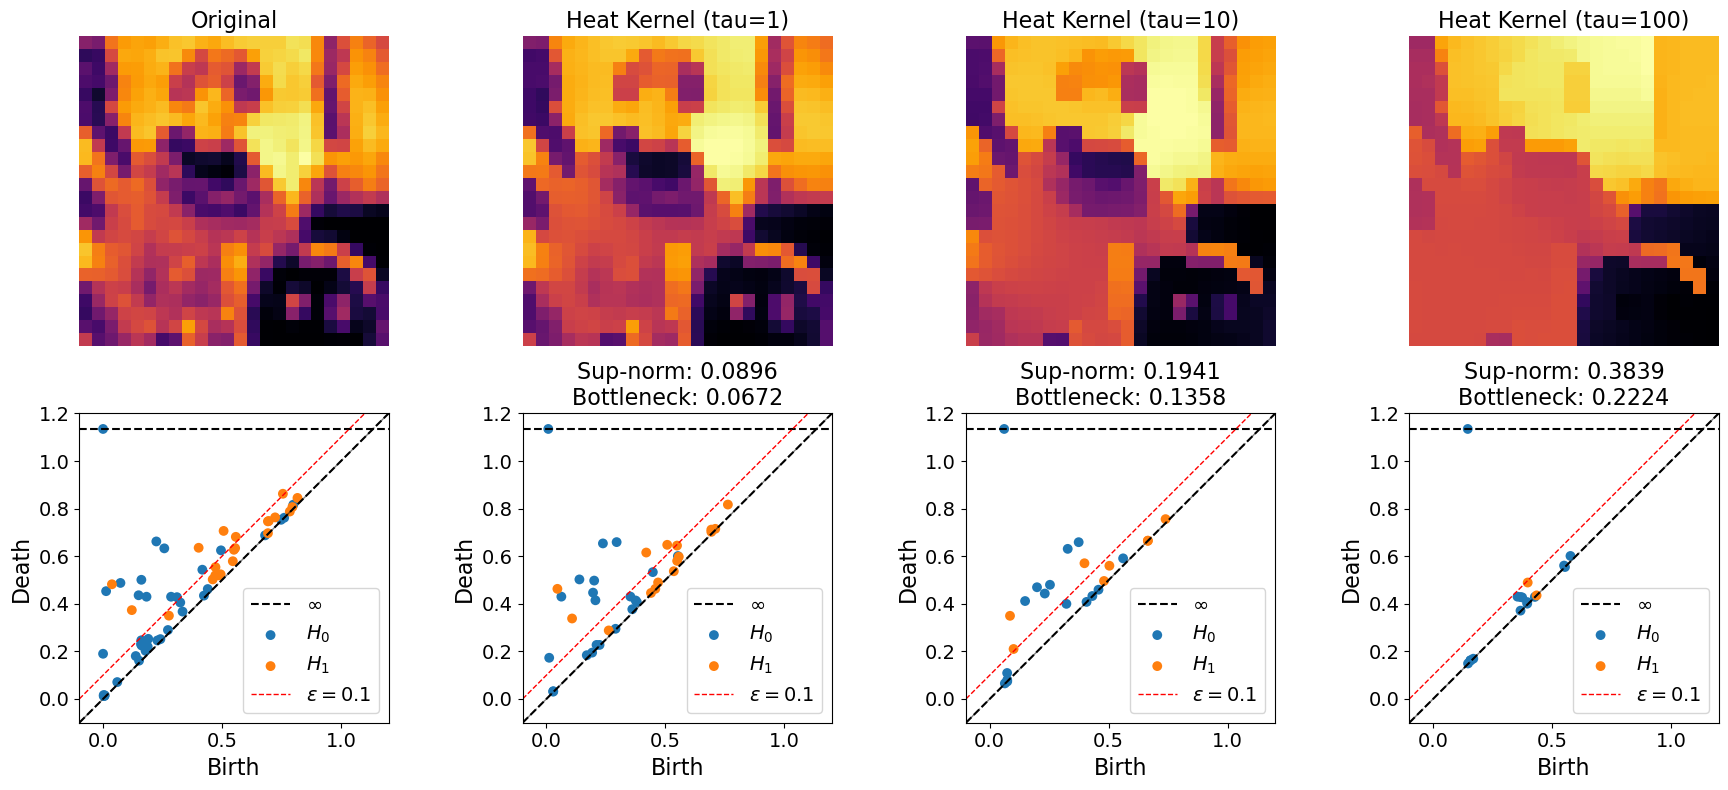

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix, diags
from scipy.sparse.linalg import eigsh
from skimage import data, color
from skimage.transform import resize
import cripser
import persim
from matplotlib import rc_context

import matplotlib.pyplot as plt
plt.rcdefaults()

plt.rc('axes', titlesize=18)      # Title font size
plt.rc('axes', labelsize=14)      # X and Y label size
plt.rc('xtick', labelsize=12)     # X tick label size
plt.rc('ytick', labelsize=12)     # Y tick label size
plt.rc('legend', fontsize=12)     # Legend font size
plt.rc('font', size=12)           # Base font size

def image_to_graph(img):
    H, W = img.shape
    N = H * W
    idx = lambda i, j: i * W + j
    rows, cols, weights = [], [], []

    for i in range(H):
        for j in range(W):
            current = idx(i, j)
            for dx, dy in [(-1,0), (1,0), (0,-1), (0,1)]:
                ni, nj = i + dx, j + dy
                if 0 <= ni < H and 0 <= nj < W:
                    neighbor = idx(ni, nj)
                    diff = img[i, j] - img[ni, nj]
                    weight = np.exp(-diff**2 / 0.01)
                    rows.append(current)
                    cols.append(neighbor)
                    weights.append(weight)

    A = coo_matrix((weights, (rows, cols)), shape=(N, N))
    A = (A + A.T) / 2
    D = diags(np.array(A.sum(axis=1)).flatten())
    L = D - A
    return L, img.reshape(-1), H, W

def spectral_filter(img, h_lambda_func, k=100):
    L, signal, H, W = image_to_graph(img)
    vals, vecs = eigsh(L, k=k, which='SM')
    h_vals = h_lambda_func(vals)
    filtered = vecs @ (h_vals * (vecs.T @ signal))
    return filtered.reshape(H, W)

def low_pass_tikhonov(img, alpha=10.0, k=100):
    return spectral_filter(img, lambda l: 1 / (1 + alpha * l), k)

def low_pass_heat(img, tau=10.0, k=100):
    return spectral_filter(img, lambda l: np.exp(-tau * l), k)

def low_pass_ideal(img, lambda_c=0.1, k=100):
    return spectral_filter(img, lambda l: (l <= lambda_c).astype(float), k)

def compute_diagram(img):
    ph = cripser.computePH(img)
    return [ph[ph[:, 0] == d, 1:3] for d in range(2)]

# Load and resize image
image = color.rgb2gray(data.astronaut())
image = resize(image, (24, 24), anti_aliasing=True)

# Apply filters
filtered_images = {
    "Original": image,
    "Heat Kernel (tau=1)": low_pass_heat(image, tau=1.0, k=575),
    "Heat Kernel (tau=10)": low_pass_heat(image, tau=10.0, k=575),
    "Heat Kernel (tau=100)": low_pass_heat(image, tau=100, k=575),
}

# Compute persistence diagrams
diagrams = {name: compute_diagram(img) for name, img in filtered_images.items()}
original_dgm = diagrams["Original"]

# Plotting
titlesize=16
eps = 0.1
fig, axes = plt.subplots(2, 4, figsize=(18, 8))
for i, (name, img) in enumerate(filtered_images.items()):
    axes[0, i].imshow(img, cmap='inferno')
    axes[0, i].set_title(name, fontsize=titlesize)
    axes[0, i].axis('off')

    # Plot persistence diagram
    persim.plot_diagrams(diagrams[name], ax=axes[1, i], size=50, xy_range=[-0.1, 1.2, -0.1, 1.2])
    x_vals = np.linspace(-0.1, 1.2, 100)
    axes[1, i].plot(x_vals, x_vals + eps, 'r--', linewidth=1, label=f'$\\varepsilon = {eps}$')
    axes[1, i].plot(x_vals, x_vals, 'k--', linewidth=1, alpha=0.5)
    
    # Compute bottleneck distance (except for Original)
    if name != "Original":
        # Compute sup-norm distance
        sup_norm = np.max(np.abs(image-img))

        # Compute bottleneck distance
        b0 = persim.bottleneck(original_dgm[0], diagrams[name][0])
        b1 = persim.bottleneck(original_dgm[1], diagrams[name][1])
        bdist = max(b0, b1)
        axes[1, i].set_title(f"Sup-norm: {sup_norm:.4f}\nBottleneck: {bdist:.4f}", fontsize=titlesize)

    axes[1, i].set_xlabel("Birth", fontsize=16)
    axes[1, i].set_ylabel("Death", fontsize=16)
    axes[1, i].tick_params(axis='both', labelsize=14)
    axes[1, i].legend(fontsize=14)

plt.tight_layout()
if SAVE_PLOTS:
    plt.savefig(PLOTS_DIR + "astr-heat-kernel.pdf")
plt.show()


# Functions

In [3]:
import numpy as np
from scipy.sparse import coo_matrix, csr_matrix, diags, eye

def image_to_graph(img, normalized=False, gaussian_weights=True, sigma=0.1):
    """
    Construct a graph Laplacian from a 2D grayscale image.

    Parameters
    ----------
    img : np.ndarray
        A 2D grayscale image of shape (H, W).
    normalized : bool, optional
        If True, compute the symmetric normalized Laplacian.
        If False, compute the combinatorial (unnormalized) Laplacian.
    gaussian_weights : bool, optional
        If True, use Gaussian weights based on pixel intensity differences.
        If False, assign uniform weight = 1 to all edges.
    sigma : float, optional
        Standard deviation used in the Gaussian kernel for edge weights.
        Only relevant when gaussian_weights=True.

    Returns
    -------
    L : scipy.sparse.csr_matrix
        The computed Laplacian matrix of shape (H*W, H*W).
    signal : np.ndarray
        The flattened input image of shape (H*W,).
    H : int
        The height of the input image.
    W : int
        The width of the input image.

    Notes
    -----
    - The graph is constructed using 4-neighbor connectivity (up, down, left, right).
    - When `gaussian_weights=True`, the edge weight between pixels i and j is:
        w_ij = exp( - (img[i] - img[j])^2 / sigma^2 )
    - When `gaussian_weights=False`, all valid edges receive weight 1.0.
    - The adjacency matrix is symmetrized: A <- (A + A^T) / 2.
    """
    H, W = img.shape
    N = H * W
    signal = img.reshape(-1)

    idx = lambda i, j: i * W + j
    rows, cols, weights = [], [], []

    for i in range(H):
        for j in range(W):
            current = idx(i, j)
            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                ni, nj = i + dx, j + dy
                if 0 <= ni < H and 0 <= nj < W:
                    neighbor = idx(ni, nj)
                    if gaussian_weights:
                        diff = img[i, j] - img[ni, nj]
                        weight = np.exp(-diff**2 / sigma**2)
                    else:
                        weight = 1.0
                    rows.append(current)
                    cols.append(neighbor)
                    weights.append(weight)

    A = coo_matrix((weights, (rows, cols)), shape=(N, N)).tocsr()
    A = (A + A.T) / 2  # Ensure symmetry

    degrees = np.array(A.sum(axis=1)).flatten()
    degrees[degrees == 0] = 1  # Avoid division by zero

    if normalized:
        D_inv_sqrt = diags(1.0 / np.sqrt(degrees))
        L = eye(N) - D_inv_sqrt @ A @ D_inv_sqrt
    else:
        D = diags(degrees)
        L = D - A

    return L, signal, H, W



In [4]:
from scipy.sparse.linalg import eigsh

def spectral_filter(img, h_lambda_func, k=100, normalized=False, gaussian_weights=True, sigma=0.1):
    """
    Apply spectral filtering to an image using Laplacian eigenbasis.

    Parameters:
    - img: 2D ndarray — input image
    - h_lambda_func: callable — transfer function h(λ)
    - k: int — number of eigenvectors/eigenvalues to use
    - normalized: bool — use normalized Laplacian if True
    - gaussian_weights: bool — use Gaussian weights if True, else uniform
    - sigma: float — standard deviation for Gaussian weights

    Returns:
    - filtered image (same shape as input)
    """
    L, signal, H, W = image_to_graph(
        img,
        normalized=normalized,
        gaussian_weights=gaussian_weights,
        sigma=sigma
    )

    vals, vecs = eigsh(L, k=k, which='SM')
    h_vals = h_lambda_func(vals)
    filtered = vecs @ (h_vals * (vecs.T @ signal))
    return filtered.reshape(H, W)

In [5]:
def bottleneck_distance(diag1, diag2):
    return max(
        persim.bottleneck(diag1[0], diag2[0]),
        persim.bottleneck(diag1[1], diag2[1])
    )

def count_small_intervals(diag, epsilon):
    count = 0
    for dgm in diag:
        lifetimes = dgm[:, 1] - dgm[:, 0]
        count += np.sum(lifetimes <= epsilon)
    return int(count)

def count_small_and_big_intervals(diag, epsilon):
    count_small = 0
    count_big = 0
    for dgm in diag:
        lifetimes = dgm[:, 1] - dgm[:, 0]
        count_small += np.sum(lifetimes < epsilon)
        count_big += np.sum(lifetimes >= epsilon)
    return int(count_small), int(count_big)

# Getting all the minimum topological noise

In [6]:
import matplotlib.pyplot as plt
plt.rcdefaults()

plt.rc('axes', titlesize=18)      # Title font size
plt.rc('axes', labelsize=14)      # X and Y label size
plt.rc('xtick', labelsize=12)     # X tick label size
plt.rc('ytick', labelsize=12)     # Y tick label size
plt.rc('legend', fontsize=12)     # Legend font size
plt.rc('font', size=12)           # Base font size


def optimize_filter_topological_noise(
    method, param_range, image, epsilon=0.1, k=100,
    normalized=False, gaussian_weights=False, sigma=0.1,
):
    """
    Evaluate topological noise under a given spectral filter and find optimal parameters.
    """
    # Step 1: Precompute Laplacian and eigendecomposition
    L, signal, H, W = image_to_graph(
        image,
        normalized=normalized,
        gaussian_weights=gaussian_weights,
        sigma=sigma
    )
    vals, vecs = eigsh(L, k=k, which='SM')
    original_diag = compute_diagram(image)
    _, relevant_original = count_small_and_big_intervals(original_diag, epsilon)
    
    # Step 2: Prepare storage for results
    min_noise = None
    relevant_killed = None
    best_param = None
    sup_norm_at_min = None
    bottleneck_at_min = None
    history_param, history_noise, history_sup, history_bottleneck = [], [], [], []
    history_relevant = [] # number of relevant topological features (above the epsilon threshold)

    # Step 3: Try each filter parameter
    for param in param_range:
        # Define transfer function h(lambda)
        if method == "heat":
            h = lambda l: np.exp(-param * l)
        elif method == "tikhonov":
            h = lambda l: 1 / (1 + param * l)
        elif method == "ideal_low_pass":
            h = lambda l: (l <= param).astype(float)
        elif method == "lorentzian":
            h = lambda l: 1 / (1 + (param * l)**2)
        elif method == "power":
            h = lambda l: (1 + l)**(-param)
        elif method == "rational":
            n = 2
            h = lambda l: 1 / (1 + (l / param)**n)
        elif method == "raised_cosine":
            a, b = param
            def rc(l):
                h_val = np.zeros_like(l)
                h_val[l < a] = 1.0
                mask = (l >= a) & (l <= b)
                h_val[mask] = 0.5 * (1 + np.cos(np.pi * (l[mask] - a) / (b - a)))
                return h_val
            h = rc
        else:
            raise ValueError(f"Unknown method: {method}")

        # Apply filter in spectral domain (reusing eigenbasis)
        h_vals = h(vals)
        filtered = vecs @ (h_vals * (vecs.T @ signal))
        filtered_img = filtered.reshape(H, W)

        # Evaluate
        sup_norm = np.max(np.abs(filtered_img - image))
        diag = compute_diagram(filtered_img)
        noise, relevant = count_small_and_big_intervals(diag, epsilon)
        bottleneck = bottleneck_distance(original_diag, diag)

        # Track results
        history_param.append(param)
        history_noise.append(noise)
        history_sup.append(sup_norm)
        history_bottleneck.append(bottleneck)
        history_relevant.append(relevant)

        if sup_norm <= epsilon:
            if min_noise is None or noise < min_noise:
                min_noise = noise
                relevant_killed = relevant_original - relevant
                best_param = param
                sup_norm_at_min = sup_norm
                bottleneck_at_min = bottleneck

    return min_noise, relevant_killed, sup_norm_at_min, bottleneck_at_min, best_param, history_param, history_noise, history_sup, history_bottleneck, history_relevant



In [7]:
def plot_results(methods_results, epsilon=0.1, save_plot_as=None, full_name=""):
    """ Plot results from `optimize_filter_topological_noise`.
    """
    min_noise = methods_results[full_name]["min_noise"]
    best_param = methods_results[full_name]["best_param"]
    history_param = methods_results[full_name]["history_param"]
    history_noise = methods_results[full_name]["history_noise"]
    history_sup = methods_results[full_name]["history_sup"]
    history_bottleneck = methods_results[full_name]["history_bottleneck"]
    history_relevant = methods_results[full_name]["history_relevant"]

    colors = {
    "blue": "#1f77b4",
    "orange": "#ff7f0e",
    "green": "#2ca02c",
    "red": "#d62728",
    "purple": "#9467bd"
    }

    print(f"Plotting {full_name}")
    fig, axs = plt.subplots(2, 1, figsize=(8, 8))

    axs[0].plot(history_param, history_noise, marker='x', label="Topological noise", color=colors['purple'])
    axs[0].plot(history_param, history_relevant, marker='o', label="Topologically relevant features", color=colors['green'])
    axs[0].set_ylabel(f"# Intervals (≤ ε = {epsilon})")
    if min_noise is not None:
        axs[0].axhline(min_noise, linestyle='--', color='gray')
        axs[0].axvline(best_param, linestyle='-.', color=colors['red'], alpha=0.5)
    axs[0].legend()

    axs[1].plot(history_param, history_sup, marker='s', linestyle='-', label="Sup Norm", color=colors['blue'])
    axs[1].plot(history_param, history_bottleneck, marker='^', linestyle='--', label="Bottleneck Distance", color=colors['orange'])
    axs[1].axhline(epsilon, linestyle=':', color='gray', label=f"ε = {epsilon}")
    if best_param is not None:
        axs[1].axvline(best_param, linestyle='-.', color=colors['red'], alpha=0.5)
    axs[1].set_ylabel("Distance to Original")
    axs[1].set_xlabel("Parameter")
    axs[1].legend()

    plt.tight_layout()
    if save_plot_as:
        plt.savefig(save_plot_as)
    plt.show()

In [8]:
# Prepare Dictionary to save methdos results
methods_results = {}

In [42]:
res = 120 # Resolution for parameter range

# Dictionary of methods and parameters
methods = {
    # HEAT KERNEL
    "heat_non_normalized_uniform": {
        "filter": "heat",
        "params": np.linspace(0, 0.3, res),
        "normalized": False,
        "gaussian_weights": False
    },
    "heat_non_normalized_gaussian": {
        "filter": "heat",
        "params": np.linspace(0, 2, res),
        "normalized": False,
        "gaussian_weights": True
    },
    "heat_non_normalized_gaussian_longer": {
        "filter": "heat",
        "params": np.linspace(0, 30, res), # Longer range for previous heat kernel
        "normalized": False,
        "gaussian_weights": True
    },
    "heat_normalized_uniform": {
        "filter": "heat",
        "params": np.linspace(0, 1.0, res),
        "normalized": True,
        "gaussian_weights": False
    },
    "heat_normalized_gaussian": {
        "filter": "heat",
        "params": np.linspace(0, 1.0, res),
        "normalized": True,
        "gaussian_weights": True
    },

    # IDEAL LOW PASS FILTER
    "ideal_low_pass_non_normalized_uniform": {
        "filter": "ideal_low_pass",
        "params": np.linspace(0, 9, res),
        "normalized": False,
        "gaussian_weights": False
    },
    "ideal_low_pass_non_normalized_gaussian": {
        "filter": "ideal_low_pass",
        "params": np.linspace(0, 5, res),
        "normalized": False,
        "gaussian_weights": True
    },
    "ideal_low_pass_normalized_uniform": {
        "filter": "ideal_low_pass",
        "params": np.linspace(0, 2.5, res),
        "normalized": True,
        "gaussian_weights": False
    },
    "ideal_low_pass_normalized_gaussian": {
        "filter": "ideal_low_pass",
        "params": np.linspace(0, 2.5, res),
        "normalized": True,
        "gaussian_weights": True
    },

    # TIKHONOV FILTER
    "tikhonov_non_normalized_uniform": {
        "filter": "tikhonov",
        "params": np.linspace(0, 0.2, res),
        "normalized": False,
        "gaussian_weights": False
    },
    "tikhonov_non_normalized_gaussian": {
        "filter": "tikhonov",
        "params": np.linspace(0, 8, res),
        "normalized": False,
        "gaussian_weights": True
    },
    "tikhonov_normalized_uniform": {
        "filter": "tikhonov",
        "params": np.linspace(0, 1.0, res),
        "normalized": True,
        "gaussian_weights": False
    },
    "tikhonov_normalized_gaussian": {
        "filter": "tikhonov",
        "params": np.linspace(0, 1.0, res),
        "normalized": True,
        "gaussian_weights": True
    },

    # LORENTZIAN FILTER
    "lorentzian_non_normalized_uniform": {
        "filter": "lorentzian",
        "params": np.linspace(0, 0.4, res),
        "normalized": False,
        "gaussian_weights": False
    },
    "lorentzian_non_normalized_gaussian": {
        "filter": "lorentzian",
        "params": np.linspace(0, 10, res),
        "normalized": False,
        "gaussian_weights": True
    },
    "lorentzian_normalized_uniform": {
        "filter": "lorentzian",
        "params": np.linspace(0, 2.0, res),
        "normalized": True,
        "gaussian_weights": False
    },
    "lorentzian_normalized_gaussian": {
        "filter": "lorentzian",
        "params": np.linspace(0, 1.5, res),
        "normalized": True,
        "gaussian_weights": True
    },

    # POWER FILTER
    "power_non_normalized_uniform": {
        "filter": "power",
        "params": np.linspace(0, 0.4, res),
        "normalized": False,
        "gaussian_weights": False
    },
    "power_non_normalized_gaussian": {
        "filter": "power",
        "params": np.linspace(0, 4, res),
        "normalized": False,
        "gaussian_weights": True
    },
    "power_normalized_uniform": {
        "filter": "power",
        "params": np.linspace(0, 1.0, res),
        "normalized": True,
        "gaussian_weights": False
    },
    "power_normalized_gaussian": {
        "filter": "power",
        "params": np.linspace(0, 1.5, res),
        "normalized": True,
        "gaussian_weights": True
    },

    # RATIONAL FILTER
    "rational_non_normalized_uniform": {
        "filter": "rational",
        "params": np.linspace(0.05, 10.0, res),
        "normalized": False,
        "gaussian_weights": False
    },
    "rational_non_normalized_gaussian": {
        "filter": "rational",
        "params": np.linspace(0.05, 5.0, res),
        "normalized": False,
        "gaussian_weights": True
    },
    "rational_normalized_uniform": {
        "filter": "rational",
        "params": np.linspace(0.05, 5.0, res),
        "normalized": True,
        "gaussian_weights": False
    },
    "rational_normalized_gaussian": {
        "filter": "rational",
        "params": np.linspace(0.05, 5.0, res),
        "normalized": True,
        "gaussian_weights": True
    },
}



-------
### All Low-pass filters

In [43]:
plt.close('all')

# Normalized or Gaussian Filter
nomalized = False
gaussian_weights = False
name = "heat"
epsilon = 0.1
sigma = 0.14

# Select methods based on criteria to run the function: Standard setting runs for all methods which is equivalent to names = methods.keys()
norm = [True, False]
gauss = [True, False]
filt = ["heat", "tikhonov", "ideal_low_pass", "lorentzian", "power", "rational"]
names = [
    key for key, val in methods.items()
    if val["normalized"] in norm and val["gaussian_weights"] in gauss and val["filter"] in filt
] + ["heat_non_normalized_gaussian_longer"]



for name in names:

    normalized = methods[name]["normalized"]
    gaussian_weights = methods[name]["gaussian_weights"]
    params = methods[name]["params"]
    method = methods[name]["filter"]

    image = color.rgb2gray(data.astronaut())
    image = resize(image, (24, 24))

    result = optimize_filter_topological_noise(
        method=method,
        param_range=params,
        image=image,
        epsilon=epsilon,
        k=575,
        normalized=normalized,
        gaussian_weights=gaussian_weights,
        sigma=sigma,
    )

    methods_results[name] = {
        "min_noise": result[0],
        "relevant_killed": result[1],
        "sup_norm_at_min": result[2],
        "bottleneck_at_min": result[3],
        "best_param": result[4],
        "history_param": result[5],
        "history_noise": result[6],
        "history_sup": result[7],
        "history_bottleneck": result[8],
        "history_relevant": result[9],
    }


-------------------------------------
-------------------------------------
-------------------------------------
RESULTS FOR heat_non_normalized_uniform:

Minimum topological noise: 37
Sup-norm at minimum: 0.057398253054560366
Bottleneck at minimum: 0.05681161150569297
Parameter at minimum: 0.05294117647058823
Plotting heat_non_normalized_uniform


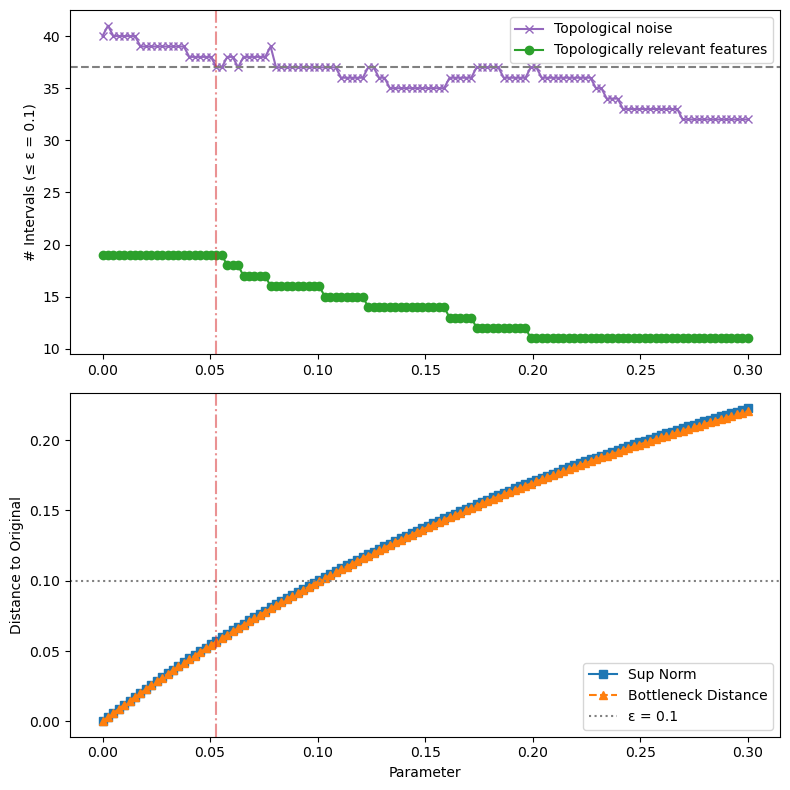

-------------------------------------
-------------------------------------
-------------------------------------
RESULTS FOR heat_non_normalized_gaussian:

Minimum topological noise: 21
Sup-norm at minimum: 0.09515981918058225
Bottleneck at minimum: 0.07465194414389699
Parameter at minimum: 0.7731092436974789
Plotting heat_non_normalized_gaussian


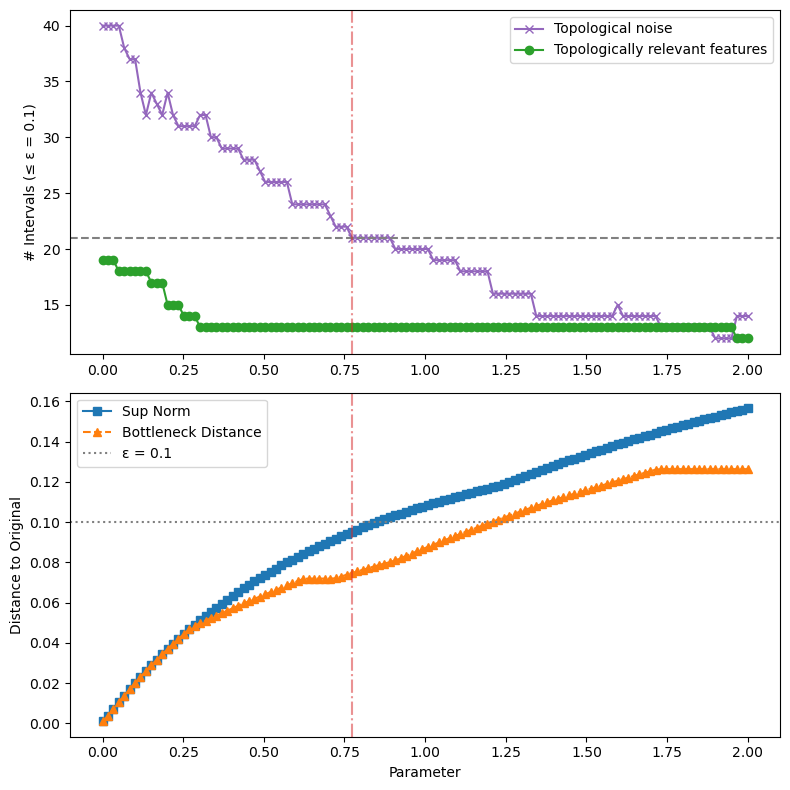

-------------------------------------
-------------------------------------
-------------------------------------
RESULTS FOR heat_non_normalized_gaussian_longer:

Minimum topological noise: 22
Sup-norm at minimum: 0.09404238453246533
Bottleneck at minimum: 0.0738031365045302
Parameter at minimum: 0.7563025210084033
Plotting heat_non_normalized_gaussian_longer


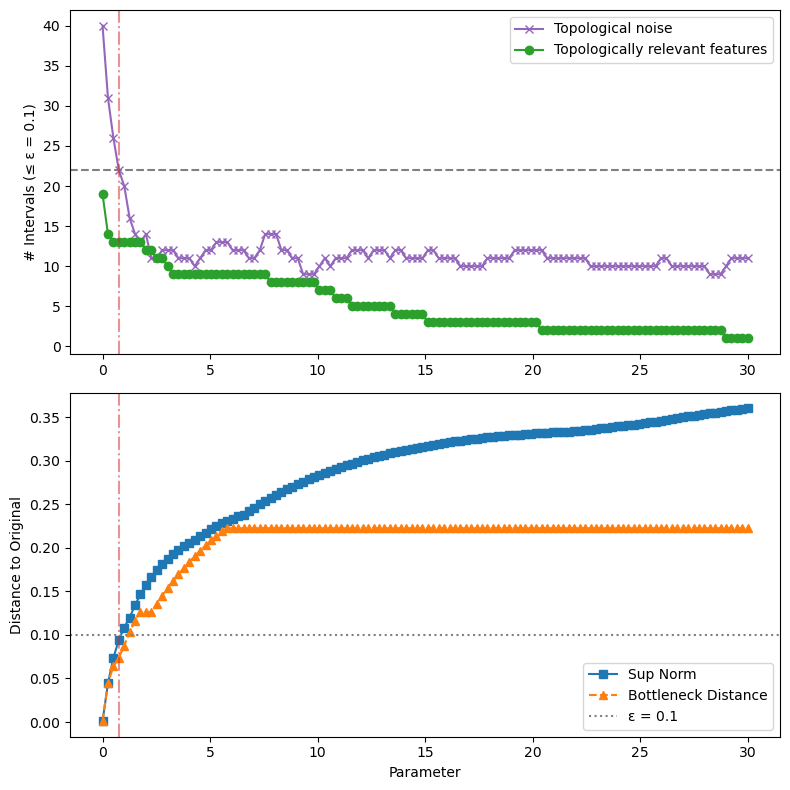

-------------------------------------
-------------------------------------
-------------------------------------
RESULTS FOR heat_normalized_uniform:

Minimum topological noise: 37
Sup-norm at minimum: 0.08439242016241144
Bottleneck at minimum: 0.08365650125530022
Parameter at minimum: 0.3277310924369748
Plotting heat_normalized_uniform


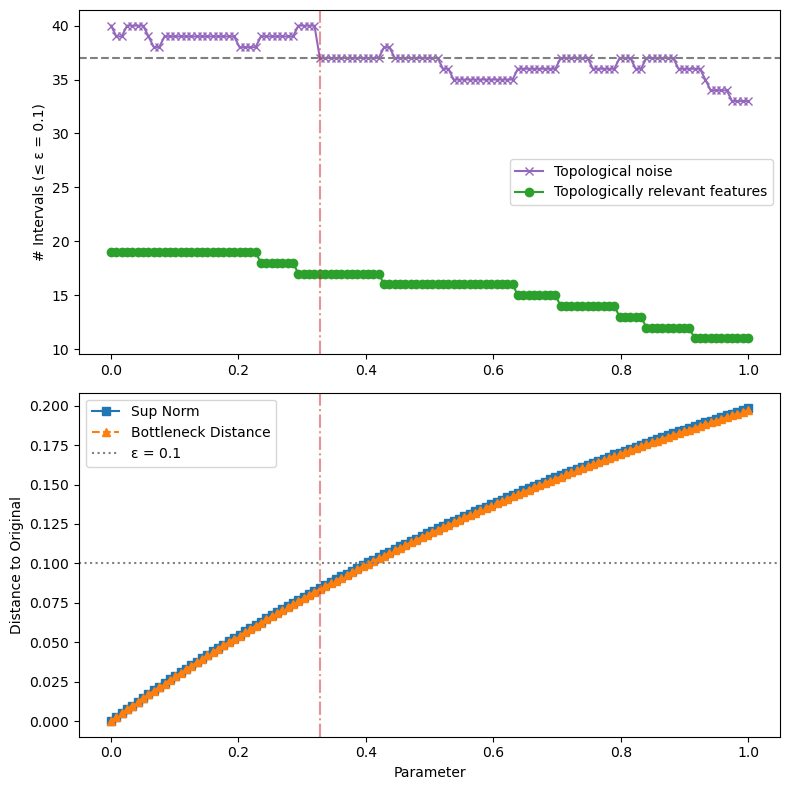

-------------------------------------
-------------------------------------
-------------------------------------
RESULTS FOR heat_normalized_gaussian:

Minimum topological noise: 34
Sup-norm at minimum: 0.09524392807863619
Bottleneck at minimum: 0.06166290955553444
Parameter at minimum: 0.2773109243697479
Plotting heat_normalized_gaussian


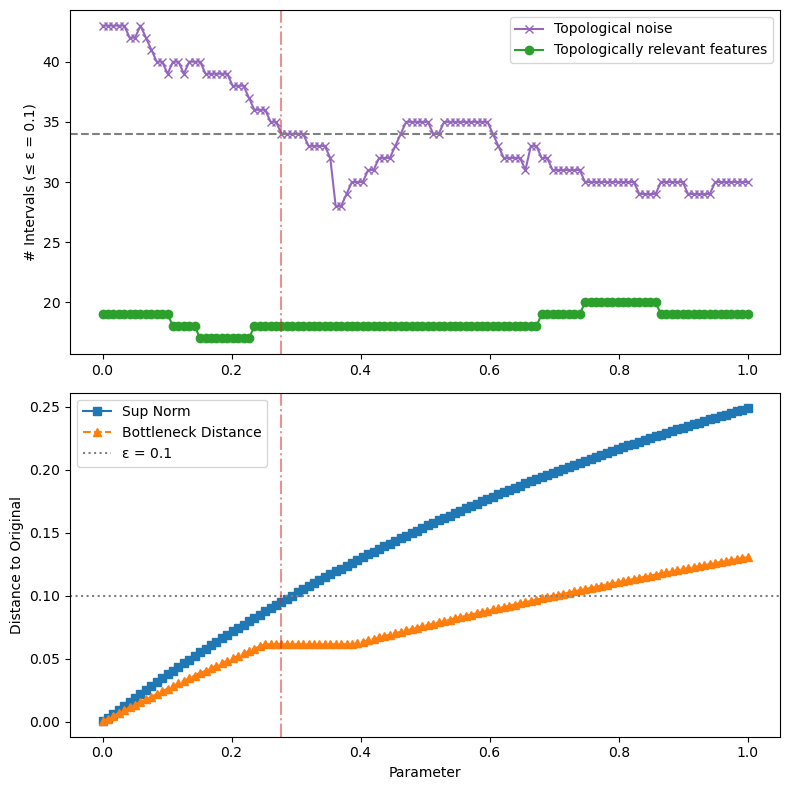

-------------------------------------
-------------------------------------
-------------------------------------
RESULTS FOR ideal_low_pass_non_normalized_uniform:

Minimum topological noise: 40
Sup-norm at minimum: 0.00025134330054699117
Bottleneck at minimum: 0.00025134330054699117
Parameter at minimum: 7.941176470588235
Plotting ideal_low_pass_non_normalized_uniform


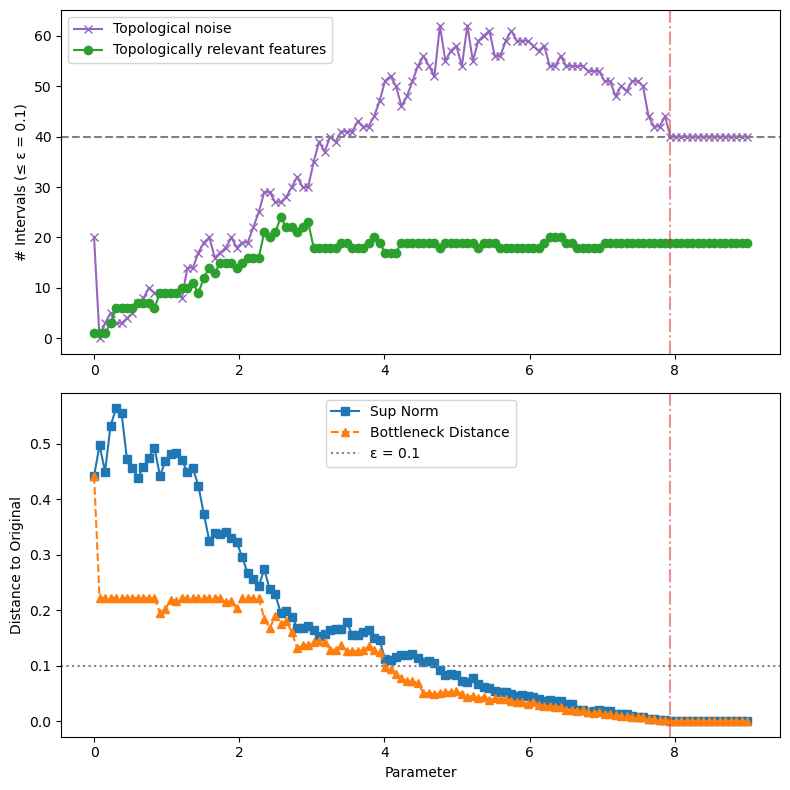

-------------------------------------
-------------------------------------
-------------------------------------
RESULTS FOR ideal_low_pass_non_normalized_gaussian:

Minimum topological noise: 17
Sup-norm at minimum: 0.08535252709286191
Bottleneck at minimum: 0.07557268907055457
Parameter at minimum: 1.596638655462185
Plotting ideal_low_pass_non_normalized_gaussian


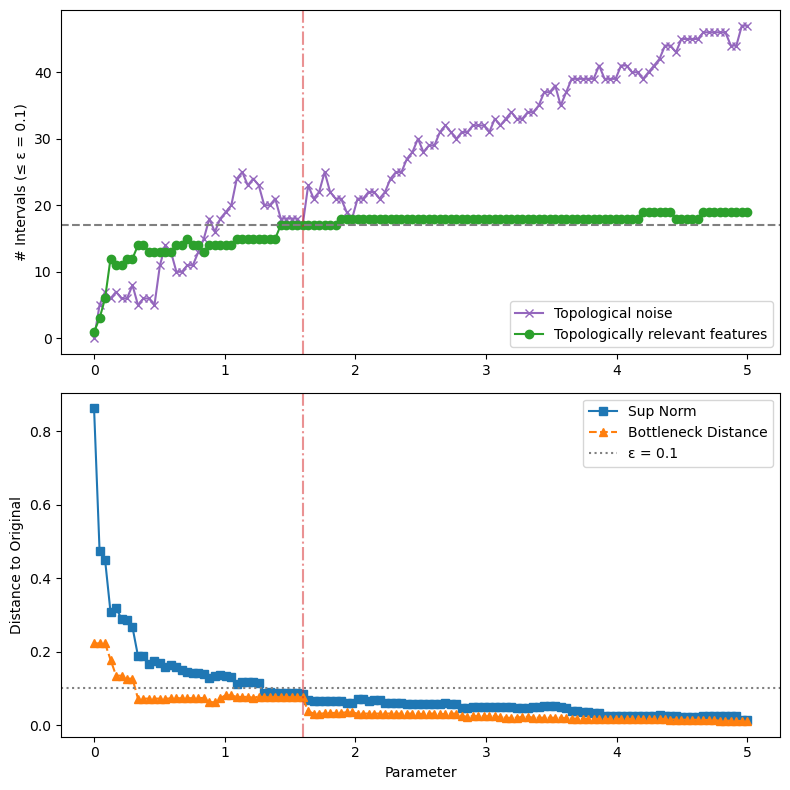

-------------------------------------
-------------------------------------
-------------------------------------
RESULTS FOR ideal_low_pass_normalized_uniform:

Minimum topological noise: 40
Sup-norm at minimum: 6.700871946208053e-08
Bottleneck at minimum: 6.700871868492442e-08
Parameter at minimum: 1.9957983193277313
Plotting ideal_low_pass_normalized_uniform


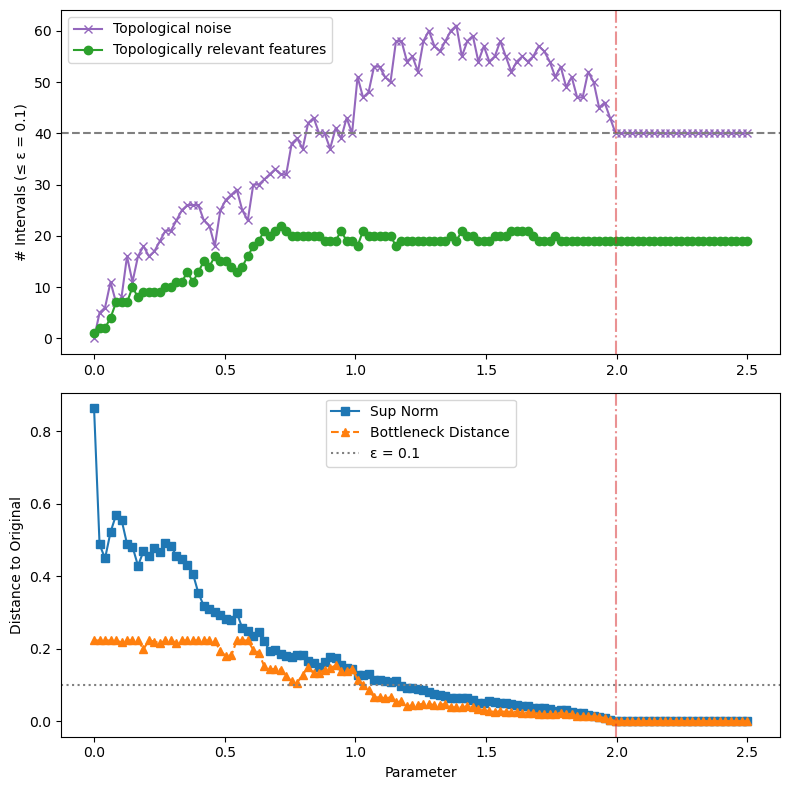

-------------------------------------
-------------------------------------
-------------------------------------
RESULTS FOR ideal_low_pass_normalized_gaussian:

Minimum topological noise: 43
Sup-norm at minimum: 0.0006811877554576415
Bottleneck at minimum: 0.0006799307836705681
Parameter at minimum: 2.0168067226890756
Plotting ideal_low_pass_normalized_gaussian


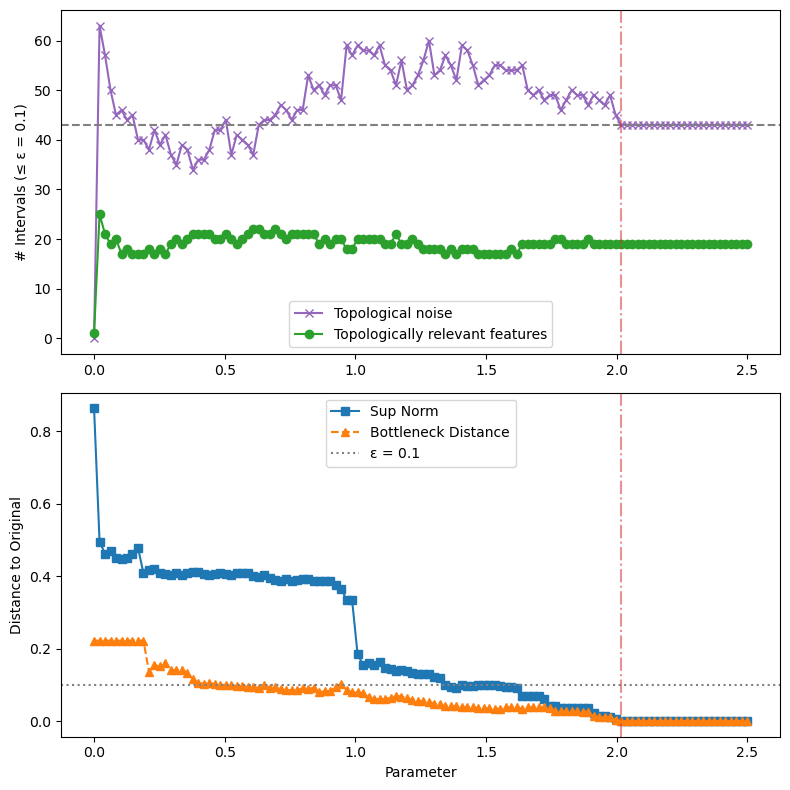

-------------------------------------
-------------------------------------
-------------------------------------
RESULTS FOR tikhonov_non_normalized_uniform:

Minimum topological noise: 37
Sup-norm at minimum: 0.05517337934069566
Bottleneck at minimum: 0.05468338155419611
Parameter at minimum: 0.055462184873949584
Plotting tikhonov_non_normalized_uniform


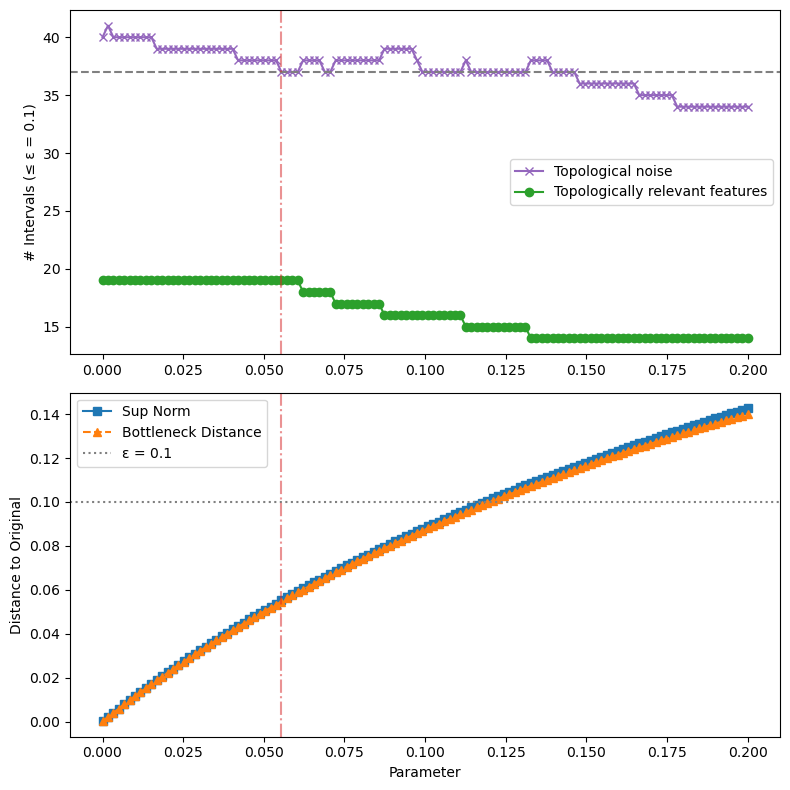

-------------------------------------
-------------------------------------
-------------------------------------
RESULTS FOR tikhonov_non_normalized_gaussian:

Minimum topological noise: 25
Sup-norm at minimum: 0.09821820410513815
Bottleneck at minimum: 0.08810693137735237
Parameter at minimum: 1.2773109243697478
Plotting tikhonov_non_normalized_gaussian


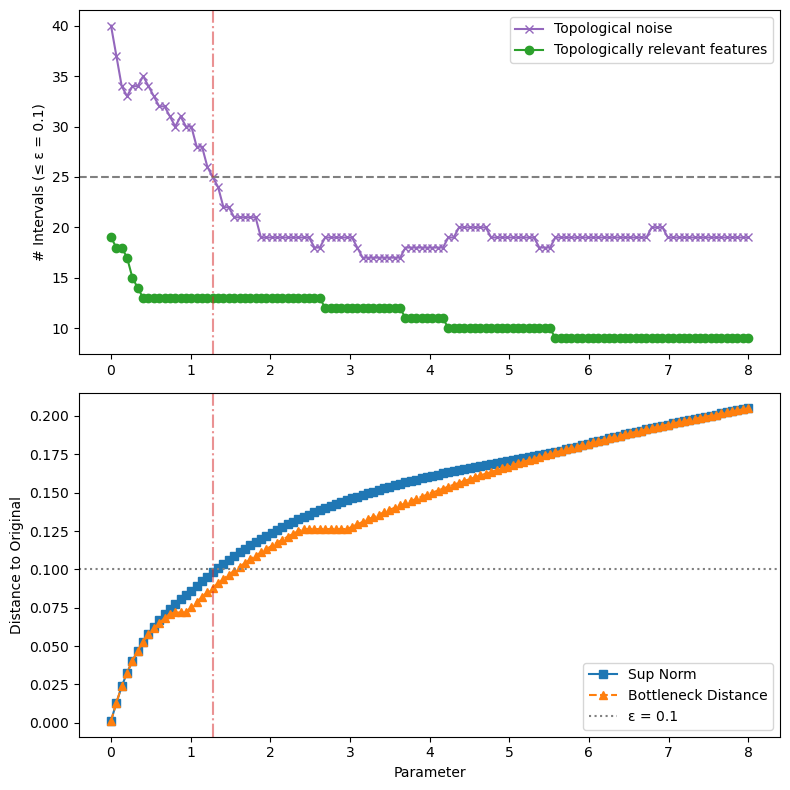

-------------------------------------
-------------------------------------
-------------------------------------
RESULTS FOR tikhonov_normalized_uniform:

Minimum topological noise: 36
Sup-norm at minimum: 0.09013131177555589
Bottleneck at minimum: 0.08930746936006312
Parameter at minimum: 0.4117647058823529
Plotting tikhonov_normalized_uniform


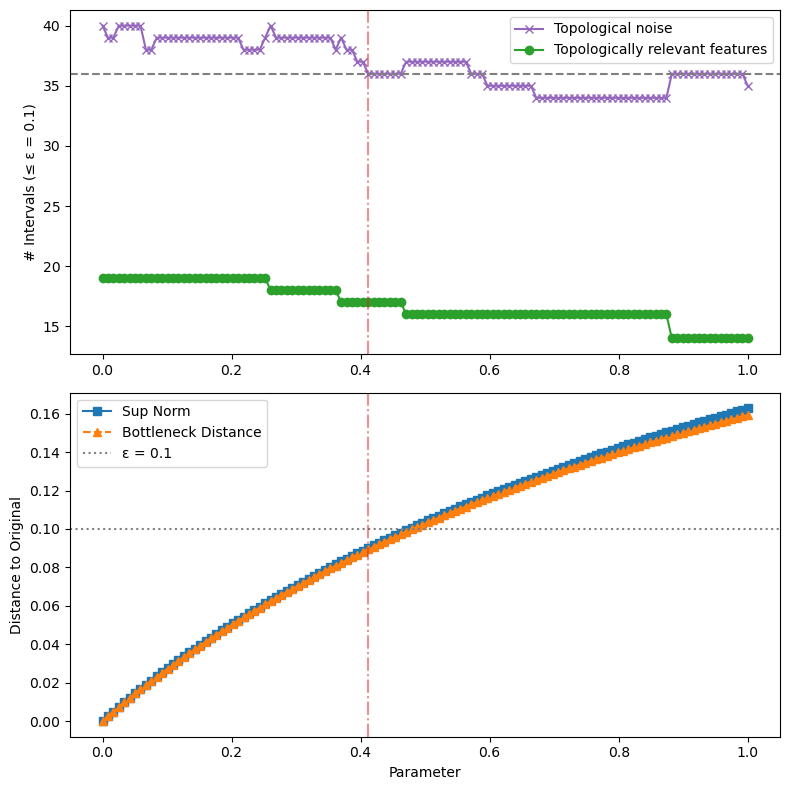

-------------------------------------
-------------------------------------
-------------------------------------
RESULTS FOR tikhonov_normalized_gaussian:

Minimum topological noise: 35
Sup-norm at minimum: 0.09704987808274324
Bottleneck at minimum: 0.06166290955553444
Parameter at minimum: 0.3277310924369748
Plotting tikhonov_normalized_gaussian


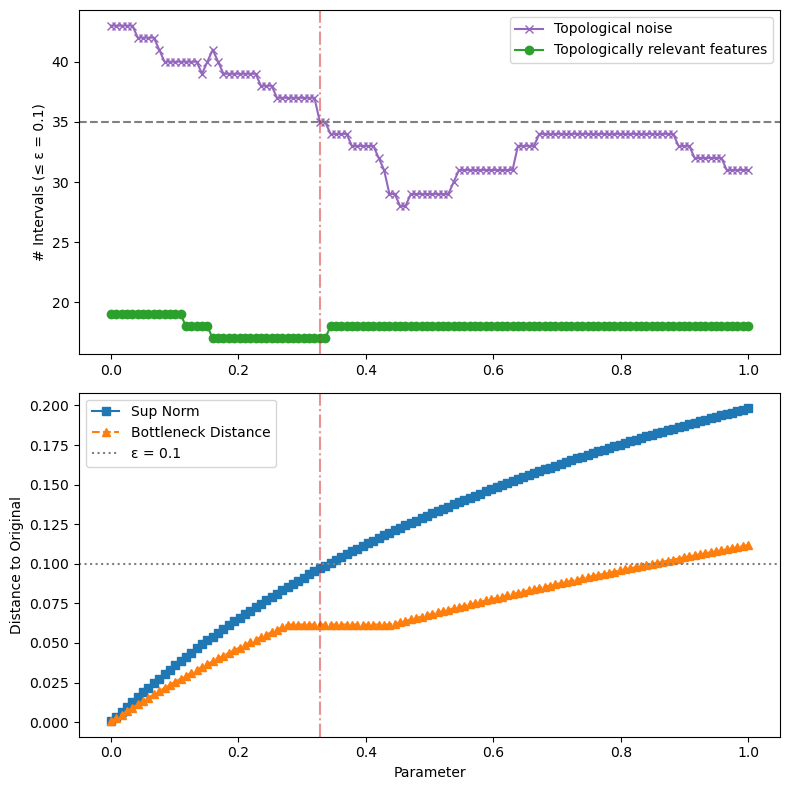

-------------------------------------
-------------------------------------
-------------------------------------
RESULTS FOR lorentzian_non_normalized_uniform:

Minimum topological noise: 37
Sup-norm at minimum: 0.09770385285448213
Bottleneck at minimum: 0.09770385285448213
Parameter at minimum: 0.1915966386554622
Plotting lorentzian_non_normalized_uniform


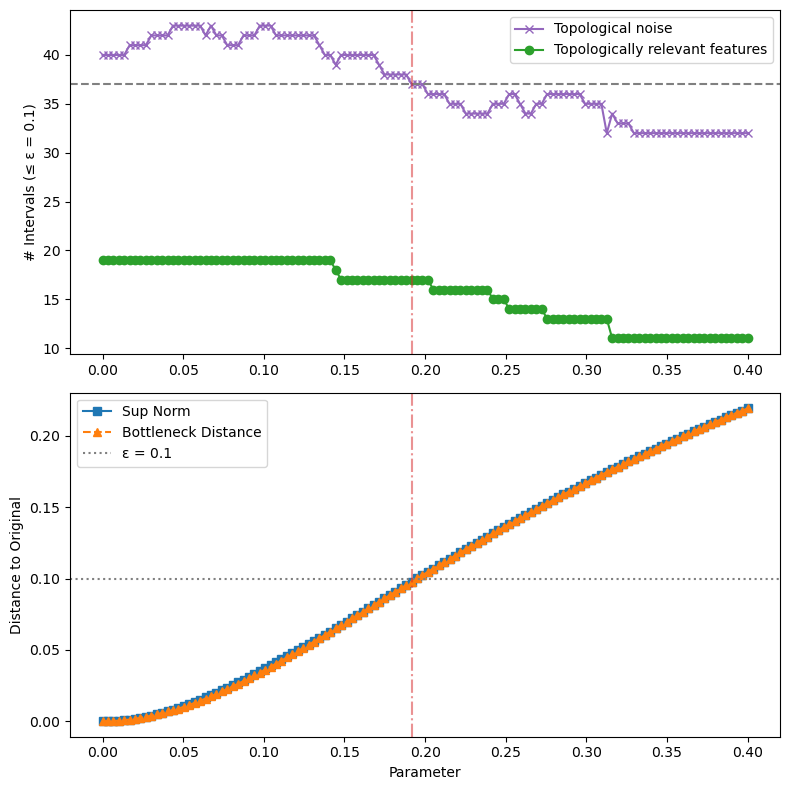

-------------------------------------
-------------------------------------
-------------------------------------
RESULTS FOR lorentzian_non_normalized_gaussian:

Minimum topological noise: 20
Sup-norm at minimum: 0.09022520251462118
Bottleneck at minimum: 0.06590819445669634
Parameter at minimum: 1.0084033613445378
Plotting lorentzian_non_normalized_gaussian


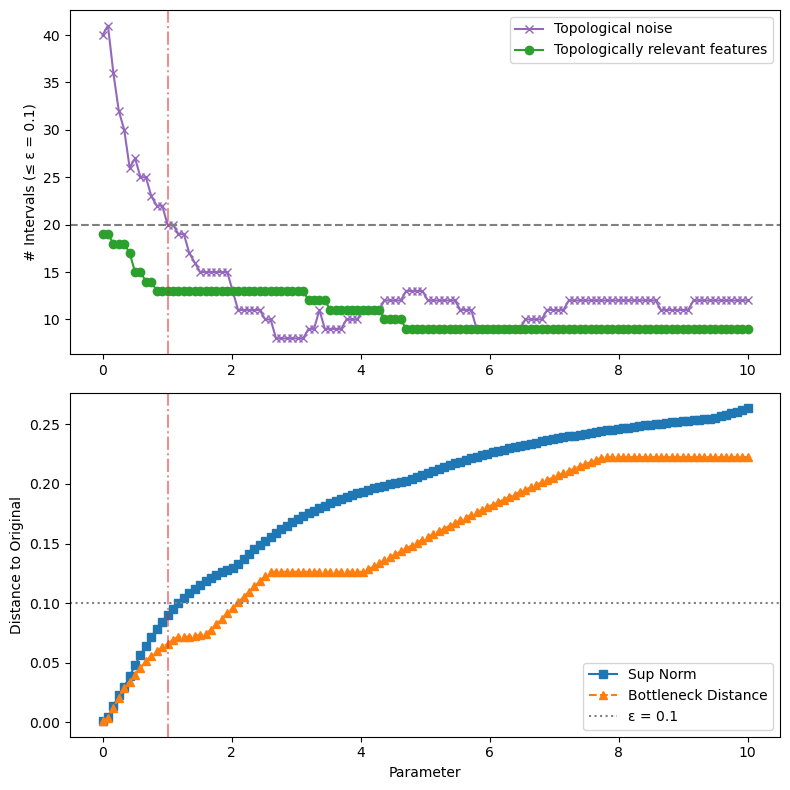

-------------------------------------
-------------------------------------
-------------------------------------
RESULTS FOR lorentzian_normalized_uniform:

Minimum topological noise: 39
Sup-norm at minimum: 0.0908093705846707
Bottleneck at minimum: 0.08717440228876222
Parameter at minimum: 0.7058823529411764
Plotting lorentzian_normalized_uniform


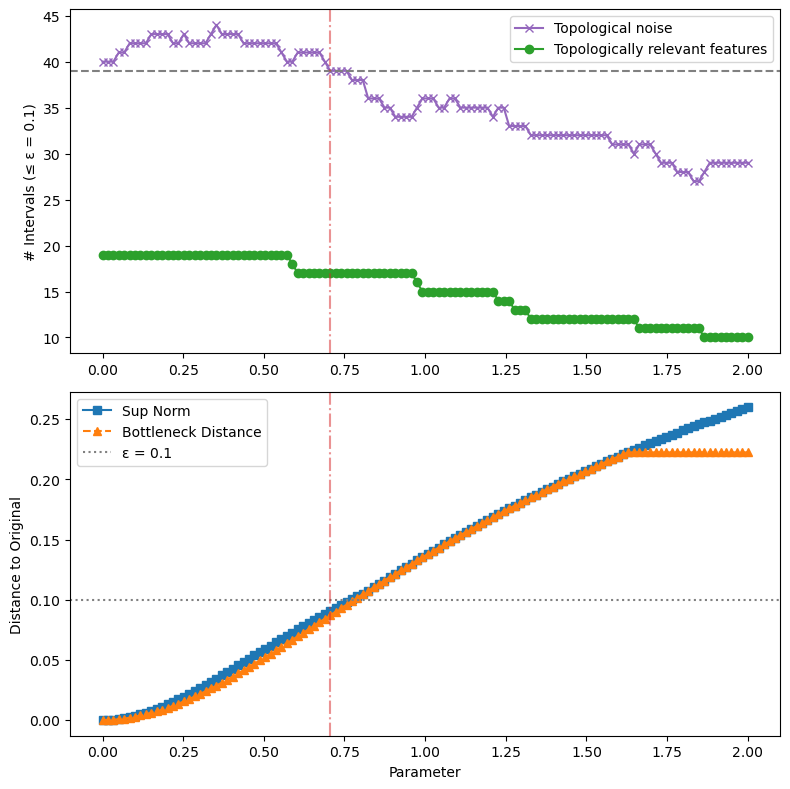

-------------------------------------
-------------------------------------
-------------------------------------
RESULTS FOR lorentzian_normalized_gaussian:

Minimum topological noise: 32
Sup-norm at minimum: 0.09921766732598536
Bottleneck at minimum: 0.05724621141534991
Parameter at minimum: 0.5798319327731093
Plotting lorentzian_normalized_gaussian


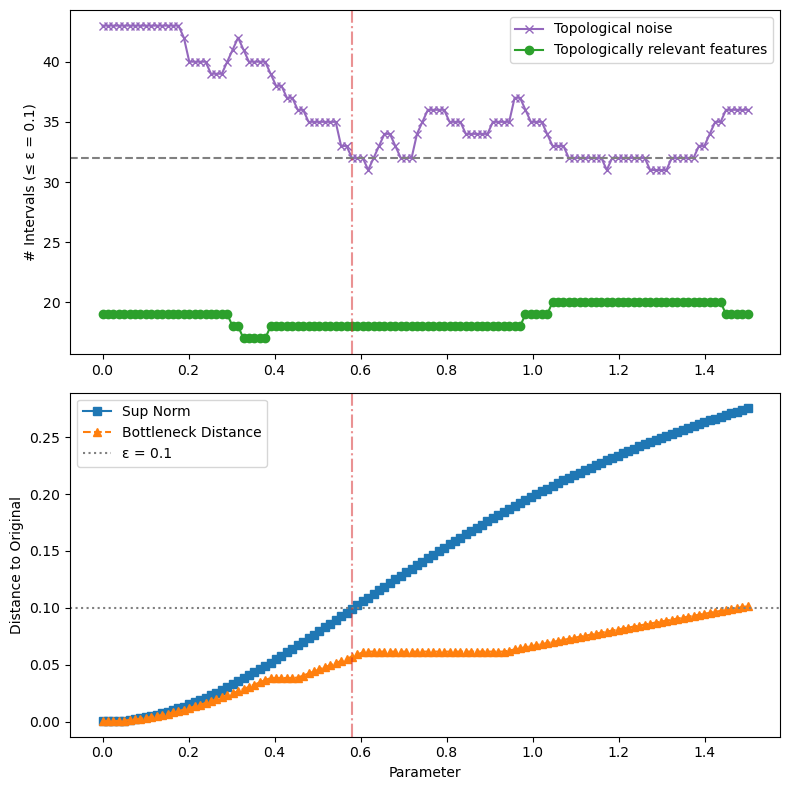

-------------------------------------
-------------------------------------
-------------------------------------
RESULTS FOR power_non_normalized_uniform:

Minimum topological noise: 36
Sup-norm at minimum: 0.0661081683308199
Bottleneck at minimum: 0.063453729117383
Parameter at minimum: 0.13445378151260506
Plotting power_non_normalized_uniform


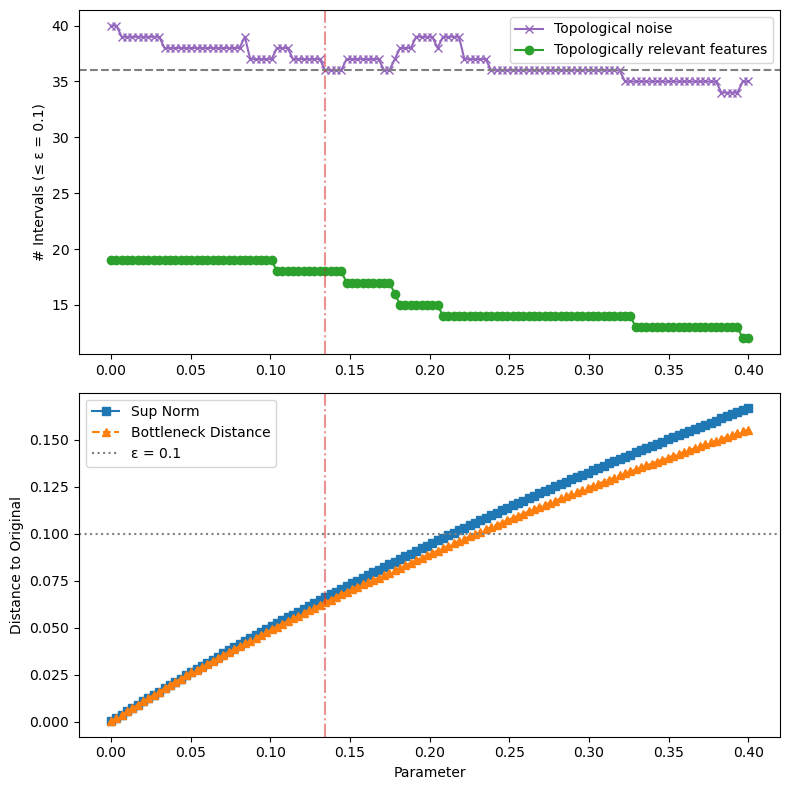

-------------------------------------
-------------------------------------
-------------------------------------
RESULTS FOR power_non_normalized_gaussian:

Minimum topological noise: 23
Sup-norm at minimum: 0.09819333802356556
Bottleneck at minimum: 0.08728941575749061
Parameter at minimum: 1.2100840336134453
Plotting power_non_normalized_gaussian


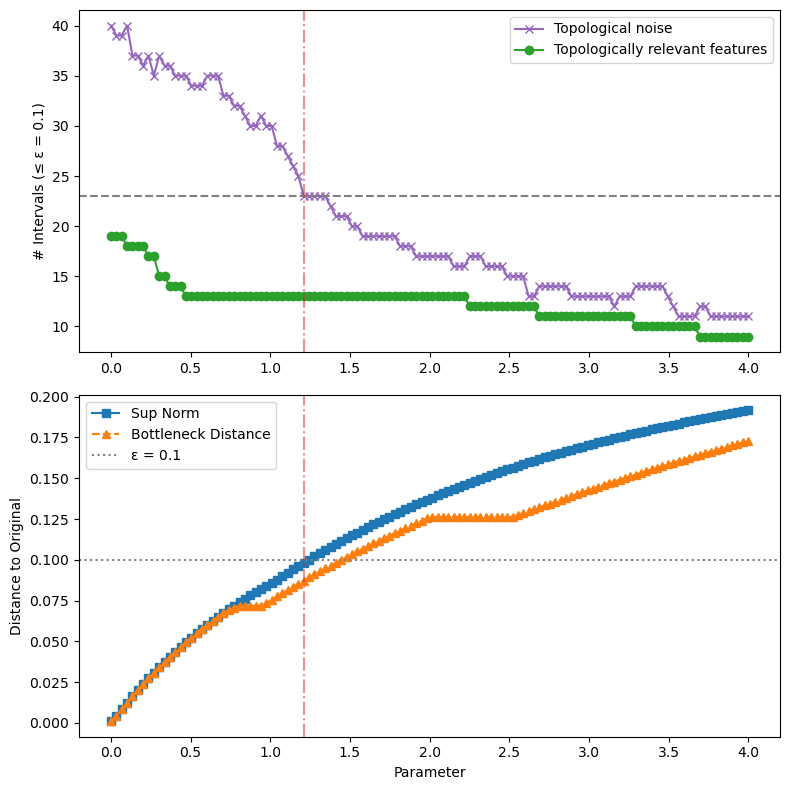

-------------------------------------
-------------------------------------
-------------------------------------
RESULTS FOR power_normalized_uniform:

Minimum topological noise: 36
Sup-norm at minimum: 0.0909499517024227
Bottleneck at minimum: 0.08954840128851038
Parameter at minimum: 0.48739495798319327
Plotting power_normalized_uniform


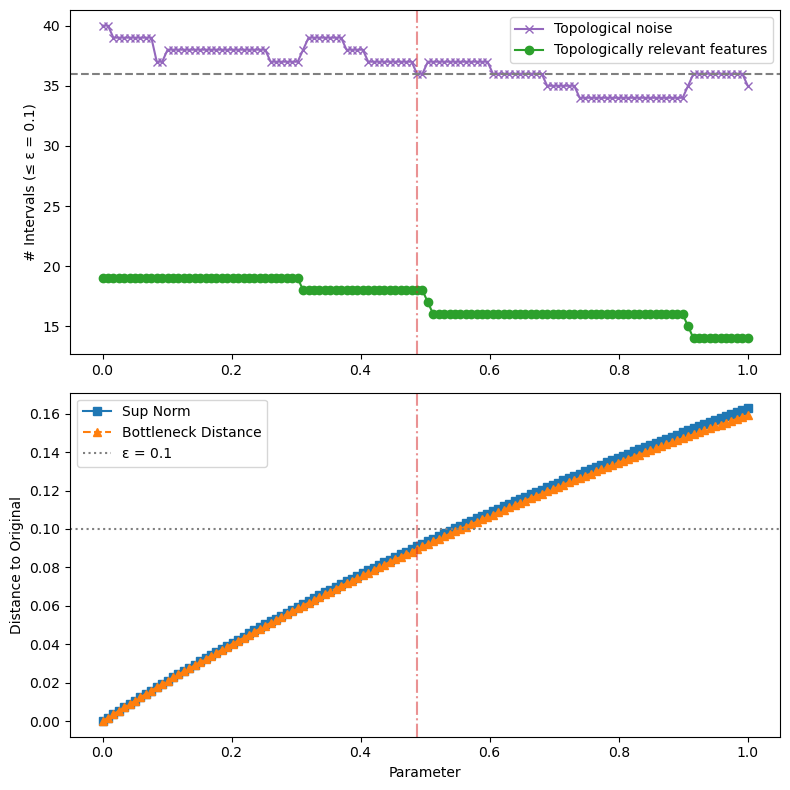

-------------------------------------
-------------------------------------
-------------------------------------
RESULTS FOR power_normalized_gaussian:

Minimum topological noise: 36
Sup-norm at minimum: 0.09873109511071909
Bottleneck at minimum: 0.06166290955553444
Parameter at minimum: 0.41596638655462187
Plotting power_normalized_gaussian


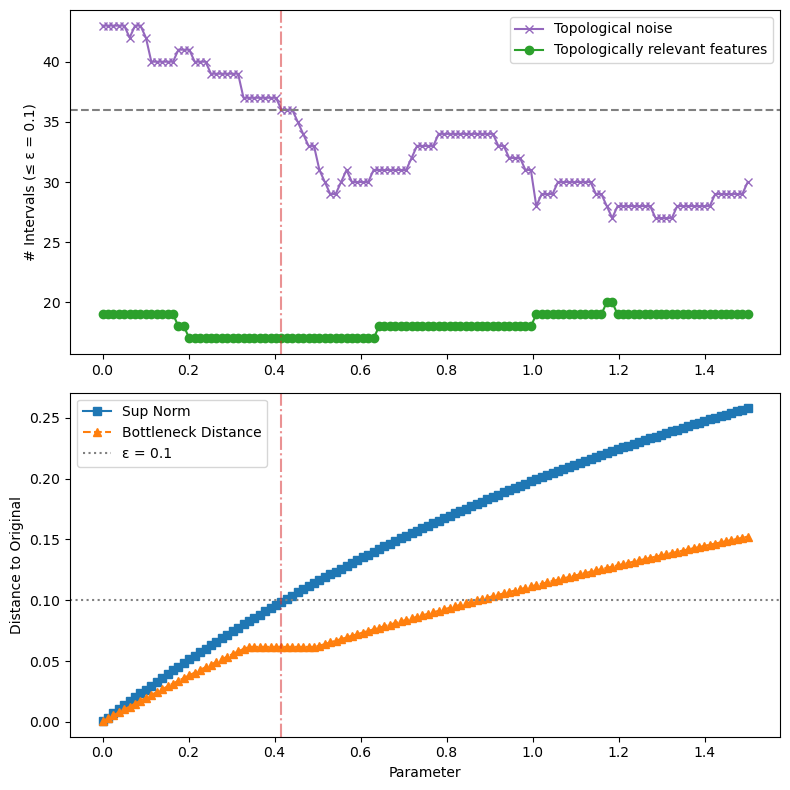

-------------------------------------
-------------------------------------
-------------------------------------
RESULTS FOR rational_non_normalized_uniform:

Minimum topological noise: 37
Sup-norm at minimum: 0.09946959540824812
Bottleneck at minimum: 0.09946959540824812
Parameter at minimum: 5.150420168067226
Plotting rational_non_normalized_uniform


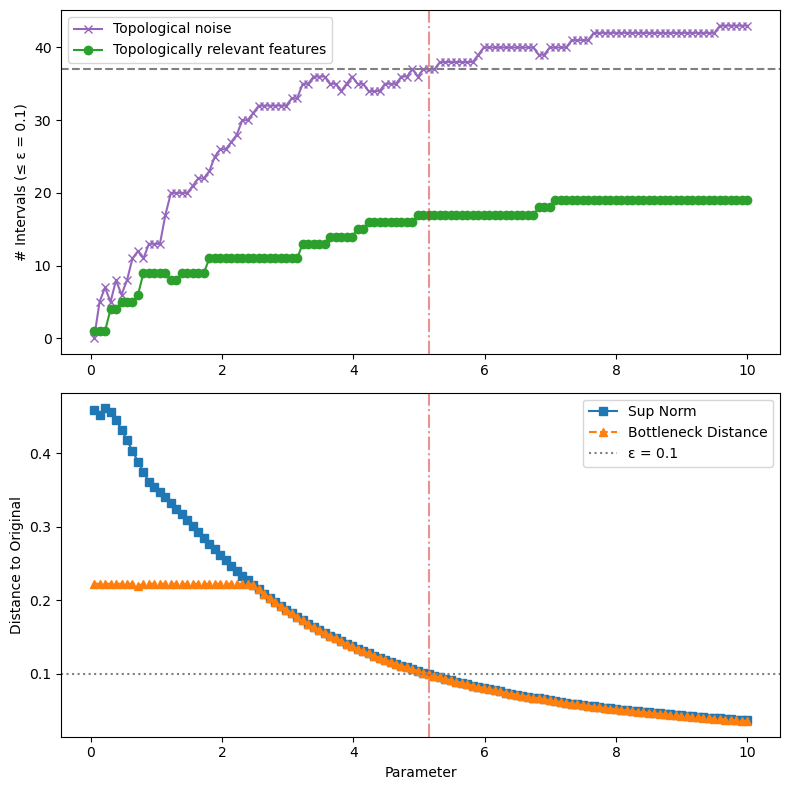

-------------------------------------
-------------------------------------
-------------------------------------
RESULTS FOR rational_non_normalized_gaussian:

Minimum topological noise: 19
Sup-norm at minimum: 0.09774110484806275
Bottleneck at minimum: 0.07150942548914574
Parameter at minimum: 0.8819327731092439
Plotting rational_non_normalized_gaussian


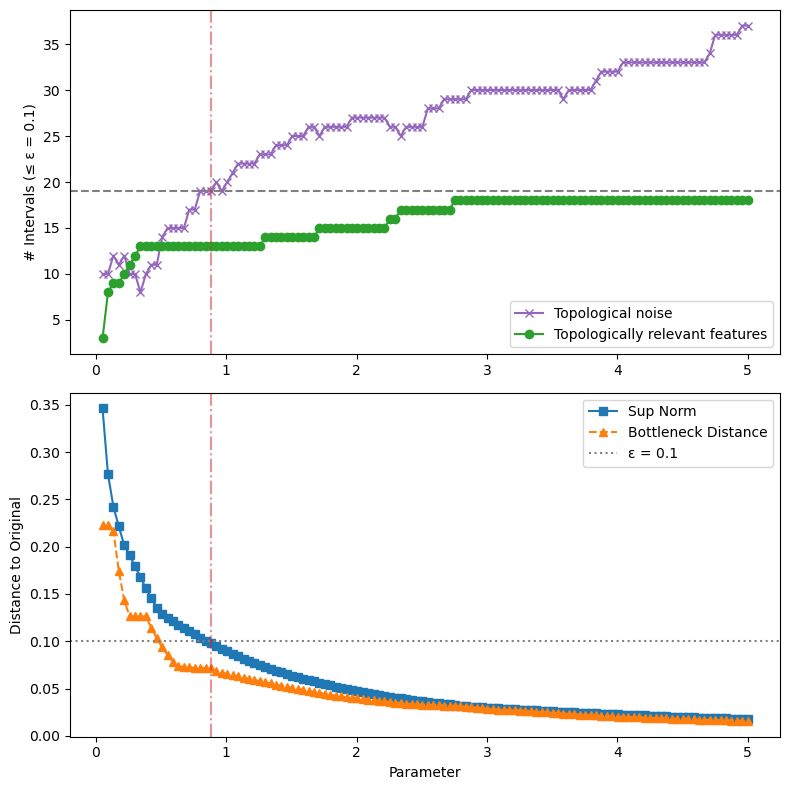

-------------------------------------
-------------------------------------
-------------------------------------
RESULTS FOR rational_normalized_uniform:

Minimum topological noise: 39
Sup-norm at minimum: 0.0967168617593735
Bottleneck at minimum: 0.09422672062150805
Parameter at minimum: 1.3394957983193279
Plotting rational_normalized_uniform


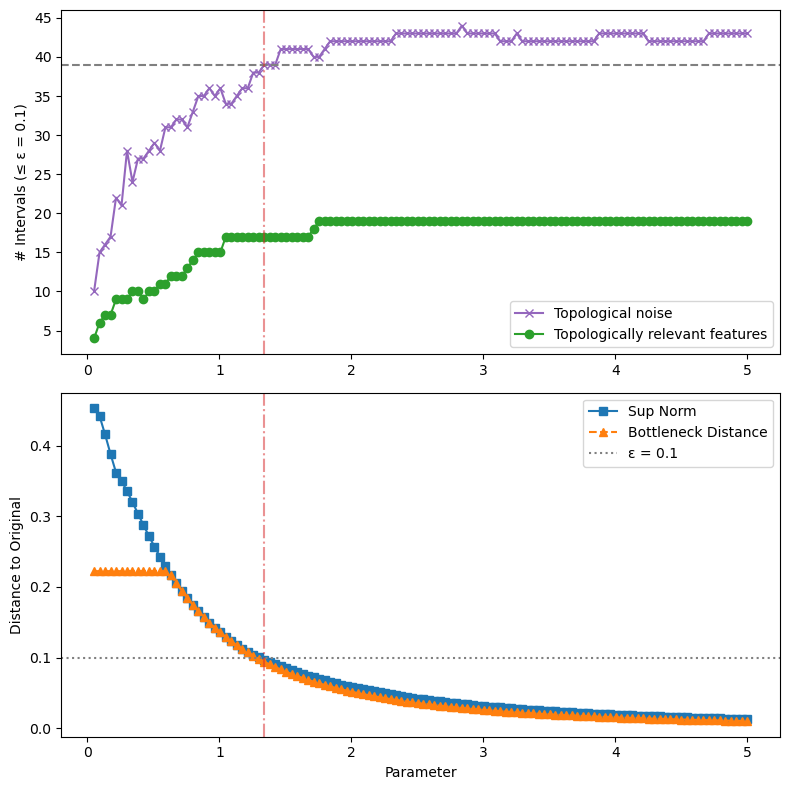

-------------------------------------
-------------------------------------
-------------------------------------
RESULTS FOR rational_normalized_gaussian:

Minimum topological noise: 32
Sup-norm at minimum: 0.09659653011359504
Bottleneck at minimum: 0.055729375994554076
Parameter at minimum: 1.7554621848739498
Plotting rational_normalized_gaussian


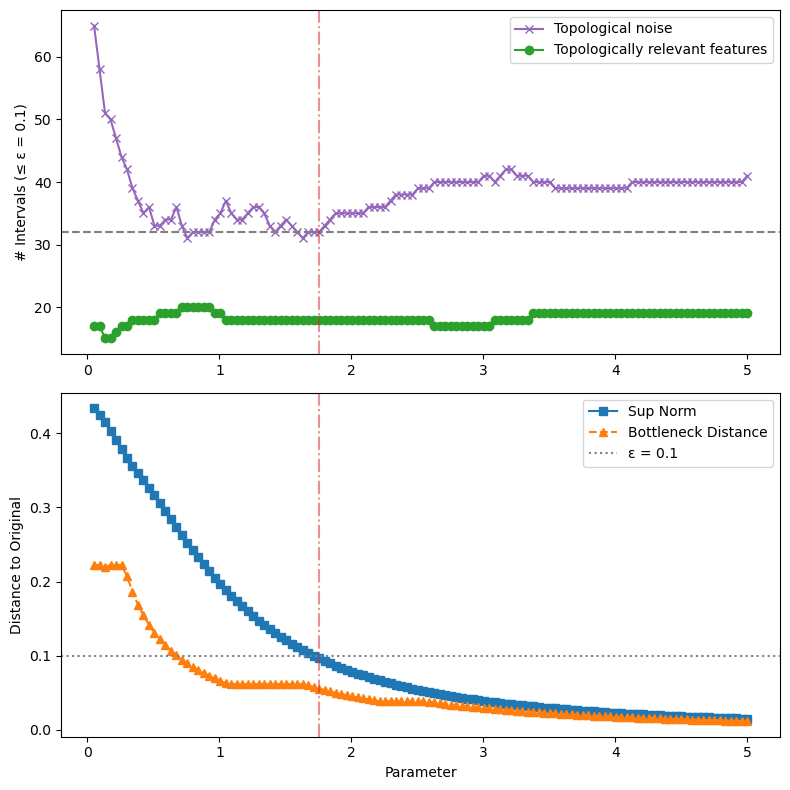

-------------------------------------
-------------------------------------
-------------------------------------
RESULTS FOR heat_non_normalized_gaussian_longer:

Minimum topological noise: 22
Sup-norm at minimum: 0.09404238453246533
Bottleneck at minimum: 0.0738031365045302
Parameter at minimum: 0.7563025210084033
Plotting heat_non_normalized_gaussian_longer


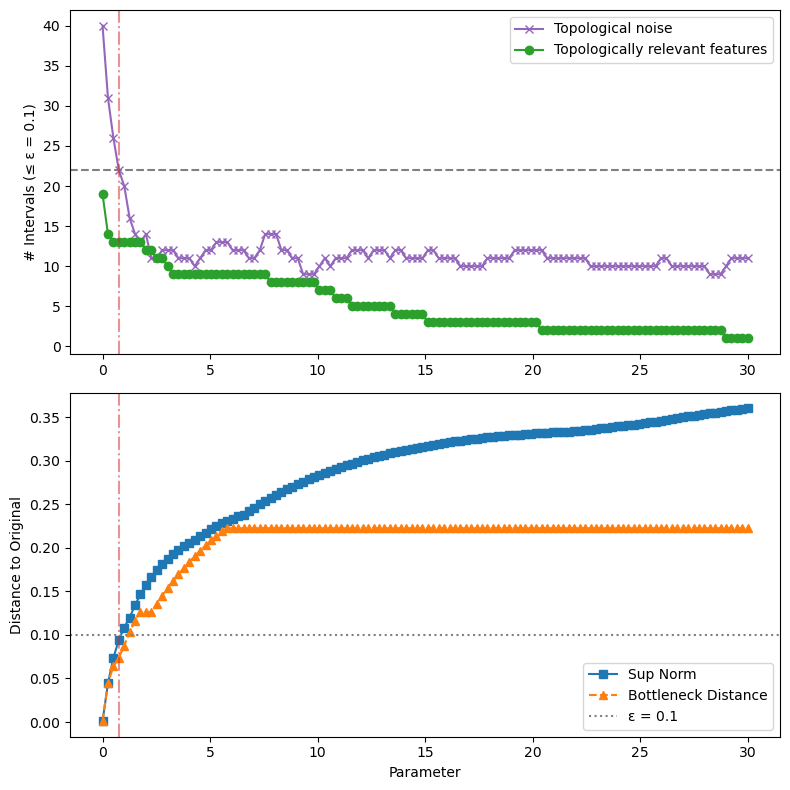

In [ ]:
for name in names:
    print("-------------------------------------")
    print("-------------------------------------")
    print("-------------------------------------")
    print(f"RESULTS FOR {name}:\n")
    print("Minimum topological noise:", methods_results[name]["min_noise"])
    print("Sup-norm at minimum:", methods_results[name]["sup_norm_at_min"])
    print("Bottleneck at minimum:", methods_results[name]["bottleneck_at_min"])
    print("Parameter at minimum:", methods_results[name]["best_param"])
    if SAVE_PLOTS:
        save_plot_as = PLOTS_DIR + f"{name}.pdf"
    else:
        save_plot_as = None
    plot_results(
        methods_results,
        epsilon=epsilon,
        full_name=name,
        save_plot_as=save_plot_as,
    )

### Raised cosine computation

In the case of the raised cosine filter there are two parameters, so we devise specific functions for this particular scenario.

In [12]:
def optimize_filter_topological_noise_2_parameters(
    method, param_range, image, epsilon=0.1, k=100,
    normalized=False, gaussian_weights=False, sigma=0.1,
    plot=False, save_plot_as=None
):
    """
    Evaluate topological noise under a given spectral filter and find optimal (a, b) parameters.
    Currently supports: 'raised_cosine'.

    Parameters
    ----------
    method : str
        The filtering method (currently only 'raised_cosine' is supported).
    param_range : list of tuple
        A list of (a, b) tuples to evaluate the filter.
    image : np.ndarray
        Input 2D grayscale image.
    epsilon : float
        Sup-norm threshold for epsilon-approximation.
    k : int
        Number of eigenvalues/eigenvectors to use.
    normalized : bool
        Whether to use the normalized Laplacian.
    gaussian_weights : bool
        Whether to use Gaussian weights (if False, uses uniform).
    sigma : float
        Sigma parameter for Gaussian weights.
    plot : bool
        Whether to generate a 2D heatmap of results.
    save_plot_as : str or None
        If provided, saves the plot to this filename.

    Returns
    -------
    min_noise, sup_norm_at_min, bottleneck_at_min, best_param,
    history_param, history_noise, history_sup, history_bottleneck
    """
    # === Precompute Laplacian and eigendecomposition ===
    L, signal, H, W = image_to_graph(
        image,
        normalized=normalized,
        gaussian_weights=gaussian_weights,
        sigma=sigma
    )
    vals, vecs = eigsh(L, k=k, which='SM')
    original_diag = compute_diagram(image)
    _, relevant_original = count_small_and_big_intervals(original_diag, epsilon)

    # === Initialization ===
    min_noise = None
    relevant_killed = None
    best_param = None
    sup_norm_at_min = None
    bottleneck_at_min = None

    history_param = []
    history_noise = []
    history_sup = []
    history_bottleneck = []
    history_relevant = []  # number of relevant topological features (above the epsilon threshold)

    # === Loop over parameter pairs ===
    for param in param_range:
        if method == "raised_cosine":
            a, b = param
            def rc(l):
                h_val = np.zeros_like(l)
                h_val[l < a] = 1.0
                mask = (l >= a) & (l <= b)
                h_val[mask] = 0.5 * (1 + np.cos(np.pi * (l[mask] - a) / (b - a)))
                return h_val
            h = rc
        else:
            raise ValueError(f"Unknown method: {method}")

        # Apply filter in spectral domain
        h_vals = h(vals)
        filtered = vecs @ (h_vals * (vecs.T @ signal))
        filtered_img = filtered.reshape(H, W)

        # Measure topological noise and distances
        sup_norm = np.max(np.abs(filtered_img - image))
        diag = compute_diagram(filtered_img)
        noise, relevant = count_small_and_big_intervals(diag, epsilon)
        bottleneck = bottleneck_distance(original_diag, diag)

        # Store results
        history_param.append(param)
        history_noise.append(noise)
        history_sup.append(sup_norm)
        history_bottleneck.append(bottleneck)
        history_relevant.append(relevant)

        if sup_norm <= epsilon:
            if min_noise is None or noise < min_noise:
                min_noise = noise
                relevant_killed = relevant_original - relevant
                best_param = param
                sup_norm_at_min = sup_norm
                bottleneck_at_min = bottleneck

    return min_noise, relevant_killed, sup_norm_at_min, bottleneck_at_min, best_param, history_param, history_noise, history_sup, history_bottleneck, history_relevant


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

def plot_results_2_parameters(methods_results, epsilon=0.1, save_plot_as=None, full_name=""):
    """ Plot results from `optimize_filter_topological_noise_2_parameters`.
    """
    min_noise = methods_results[full_name]["min_noise"]
    best_param = methods_results[full_name]["best_param"]
    history_param = methods_results[full_name]["history_param"]
    history_noise = methods_results[full_name]["history_noise"]
    history_sup = methods_results[full_name]["history_sup"]
    history_bottleneck = methods_results[full_name]["history_bottleneck"]

    a_vals = sorted(set(p[0] for p in history_param))
    b_vals = sorted(set(p[1] for p in history_param))
    A, B = np.meshgrid(a_vals, b_vals, indexing='ij')

    shape = (len(a_vals), len(b_vals))
    Z_noise = np.full(shape, np.nan)
    Z_sup = np.full(shape, np.nan)
    Z_bottleneck = np.full(shape, np.nan)

    for (a, b), noise, sup, bottleneck in zip(history_param, history_noise, history_sup, history_bottleneck):
        i = a_vals.index(a)
        j = b_vals.index(b)
        Z_noise[i, j] = noise
        Z_sup[i, j] = sup
        Z_bottleneck[i, j] = bottleneck

    # Set minimum for log scale to avoid log(0)
    epsilon_sup = np.nanmin(Z_sup[Z_sup > 0]) * 0.5
    epsilon_bottleneck = np.nanmin(Z_bottleneck[Z_bottleneck > 0]) * 0.5

    fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

    # Topological Noise (linear scale)
    im0 = axes[0].imshow(Z_noise, origin='lower', extent=[min(b_vals), max(b_vals), min(a_vals), max(a_vals)],
                         aspect='auto', cmap='inferno')
    axes[0].set_title("Topological Noise")
    axes[0].set_xlabel("$\lambda_2$")
    axes[0].set_ylabel("$\lambda_1$")
    axes[0].contour(B, A, Z_sup, levels=[0.1], colors='w', linewidths=2)
    axes[0].contour(B, A, Z_bottleneck, levels=[0.05], colors='r', linewidths=2)
    fig.colorbar(im0, ax=axes[0], location='left', pad=0.08).set_label("Noise")

    # Sup-norm (log scale)
    im1 = axes[1].imshow(Z_sup, origin='lower',
                         extent=[min(b_vals), max(b_vals), min(a_vals), max(a_vals)],
                         aspect='auto', cmap='viridis', norm=LogNorm(vmin=epsilon_sup, vmax=np.nanmax(Z_sup)))
    axes[1].set_title("Sup-norm (log scale)")
    axes[1].set_xlabel("$\lambda_2$")
    axes[1].set_ylabel("$\lambda_1$")
    CS = axes[1].contour(B, A, Z_sup, levels=[0.1], colors='w', linewidths=2)
    axes[1].clabel(CS, fmt='%.2f', colors='w', inline=True, inline_spacing=0)

    # Bottleneck Distance (log scale)
    im2 = axes[2].imshow(Z_bottleneck, origin='lower',
                         extent=[min(b_vals), max(b_vals), min(a_vals), max(a_vals)],
                         aspect='auto', cmap='viridis', norm=LogNorm(vmin=epsilon_bottleneck, vmax=np.nanmax(Z_bottleneck)))
    axes[2].set_title("Bottleneck Distance (log scale)")
    axes[2].set_xlabel("$\lambda_2$")
    axes[2].set_ylabel("$\lambda_1$")
    CS = axes[2].contour(B, A, Z_bottleneck, levels=[0.05], colors='r', linewidths=2)
    axes[2].clabel(CS, colors='r', inline=True, inline_spacing=0)
    fig.colorbar(im2, ax=axes[2], location='right').set_label("Sup-norm / Bottleneck")

    # Mark the minimum point
    axes[0].plot(best_param[1], best_param[0], 'o', color='lime', label='Minimum', markersize=8)
    axes[0].legend(loc='upper left')

    if save_plot_as:
        plt.savefig(save_plot_as, bbox_inches='tight')
    plt.show()


In [14]:
""" This section optimizes the raised cosine filter with two parameters (lambda_1, lambda_2).
    COMPUTATIONS MAY TAKE A WHILE, depending on the resolution and the image size.
    For the standard resolution set below (res=32), it takes about 2 minutes on a standard laptop.
    Reduce `res` to speed up the computation, e.g., `res = 8`.
"""
res = 32  # Resolution for parameter range
epsilon = 0.1
sigma = 0.14  # Sigma for Gaussian weights, if applicable

raised_cosine_dict = {
    # HEAT KERNEL
    "raised_cosine_non_normalized_uniform": {
        "filter": "raised_cosine",
        "params": [(a, b) for a in np.linspace(0.0, 5, res) for b in np.linspace(5, 15, res) if a < b],
        "normalized": False,
        "gaussian_weights": False
    },
    "raised_cosine_non_normalized_gaussian": {
        "filter": "raised_cosine",
        "params": [(a, b) for a in np.linspace(0.0, 2.0, res) for b in np.linspace(0, 4, res) if a < b],
        "normalized": False,
        "gaussian_weights": True
    },
    "raised_cosine_normalized_uniform": {
        "filter": "raised_cosine",
        "params": [(a, b) for a in np.linspace(0.0, 1.5, res) for b in np.linspace(0, 5, res) if a < b],
        "normalized": True,
        "gaussian_weights": False
    },
    "raised_cosine_normalized_gaussian": {
        "filter": "raised_cosine",
        "params": [(a, b) for a in np.linspace(0.0, 1.0, res) for b in np.linspace(2, 5, res) if a < b],
        "normalized": True,
        "gaussian_weights": True
    },
}

names = raised_cosine_dict.keys()
# Select methods based on criteria to run the function: Standard setting runs for all methods which is equivalent to names = raised_cosine_dict.keys()
norm = [True, False]
gauss = [True, False]
filt = ["raised_cosine"]
# filt = ["ideal_low_pass", "rational"]
# norm = [False]
# gauss = [True]
names = [
    key for key, val in raised_cosine_dict.items()
    if val["normalized"] in norm and val["gaussian_weights"] in gauss and val["filter"] in filt
]



image = color.rgb2gray(data.astronaut())
image = resize(image, (24, 24))


for name in names:

    params = raised_cosine_dict[name]["params"]
    normalized = raised_cosine_dict[name]["normalized"]
    gaussian_weights = raised_cosine_dict[name]["gaussian_weights"]
    method = raised_cosine_dict[name]["filter"]

    result = optimize_filter_topological_noise_2_parameters(
        method=method,
        param_range=params,
        image=image,
        epsilon=epsilon,
        k=575,
        normalized=normalized,
        gaussian_weights=gaussian_weights,
        sigma=sigma,
    )

    methods_results[name] = {
        "min_noise": result[0],
        "relevant_killed": result[1],
        "sup_norm_at_min": result[2],
        "bottleneck_at_min": result[3],
        "best_param": result[4],
        "history_param": result[5],
        "history_noise": result[6],
        "history_sup": result[7],
        "history_bottleneck": result[8],
        "history_relevant": result[9],
    }


-------------------------------------
-------------------------------------
-------------------------------------
RESULTS FOR raised_cosine_non_normalized_uniform:

Minimum topological noise: 37
Sup-norm at minimum: 0.09832239997815562
Bottleneck at minimum: 0.0964683538592741
Parameter at minimum: (0.0, 9.516129032258064)


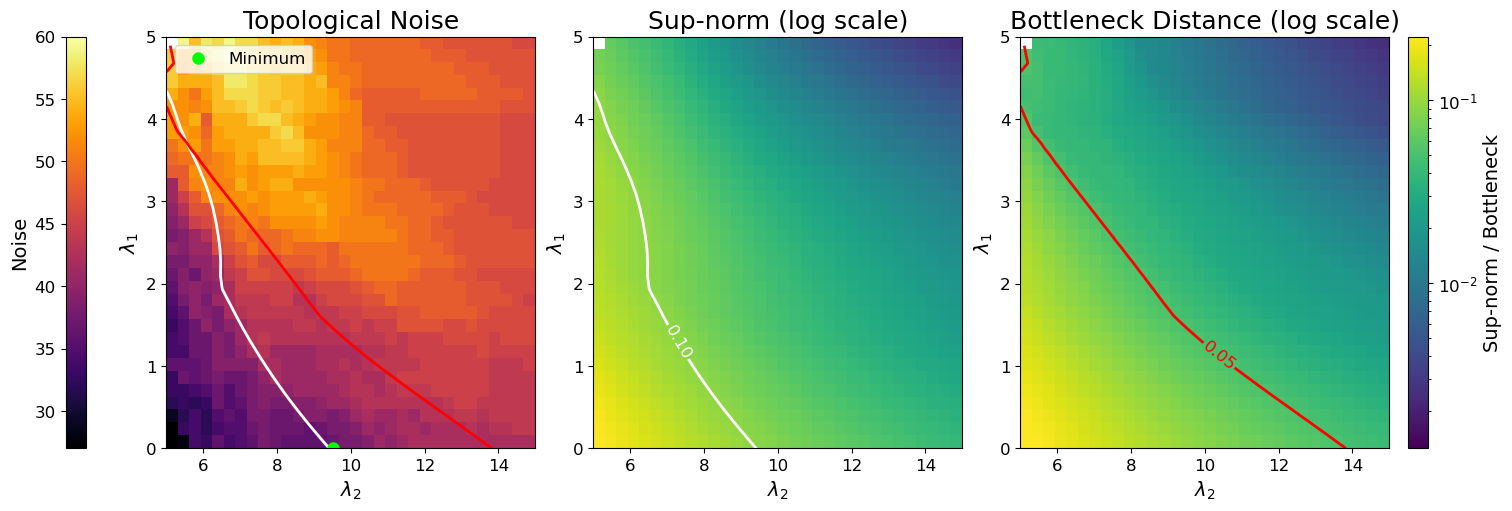

-------------------------------------
-------------------------------------
-------------------------------------
RESULTS FOR raised_cosine_non_normalized_gaussian:

Minimum topological noise: 17
Sup-norm at minimum: 0.08674971410584299
Bottleneck at minimum: 0.0757776589298323
Parameter at minimum: (1.3548387096774193, 1.5483870967741935)


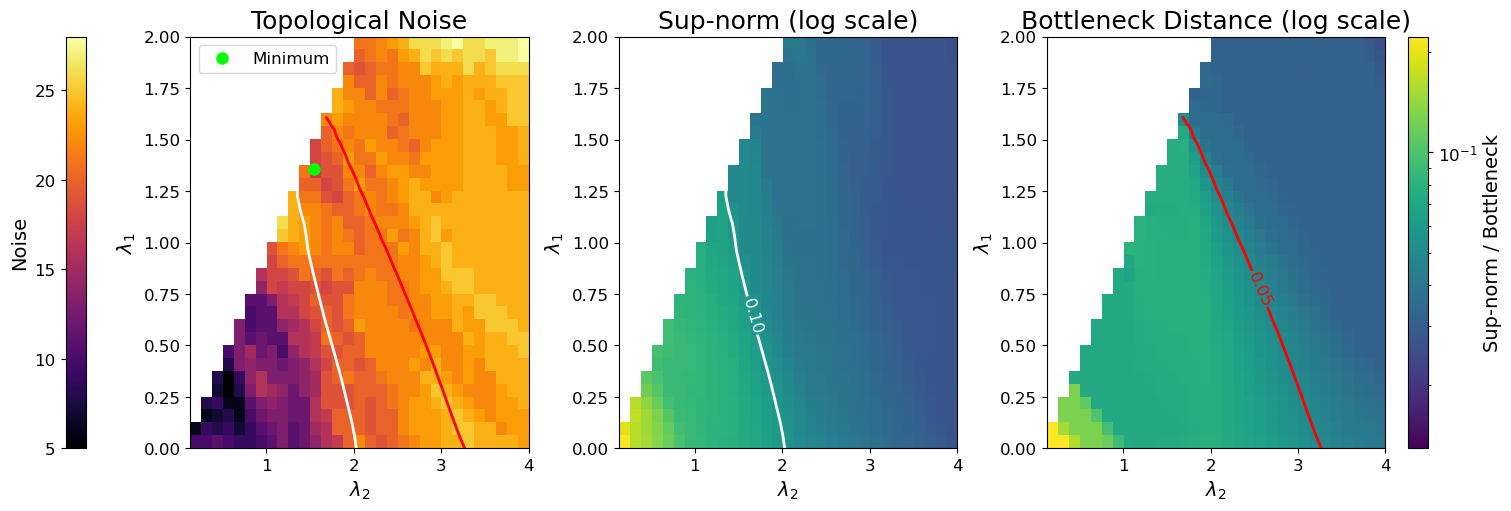

-------------------------------------
-------------------------------------
-------------------------------------
RESULTS FOR raised_cosine_normalized_uniform:

Minimum topological noise: 38
Sup-norm at minimum: 0.09873415201248231
Bottleneck at minimum: 0.08407698379533779
Parameter at minimum: (0.0, 2.5806451612903225)


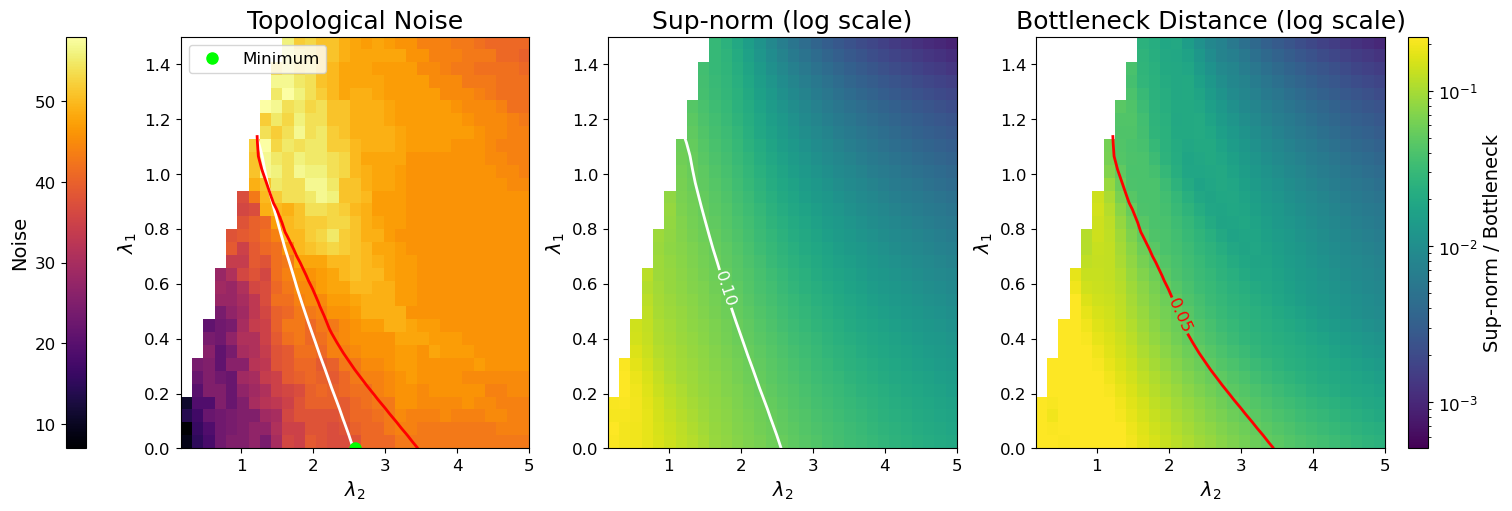

-------------------------------------
-------------------------------------
-------------------------------------
RESULTS FOR raised_cosine_normalized_gaussian:

Minimum topological noise: 32
Sup-norm at minimum: 0.08934581571855876
Bottleneck at minimum: 0.05171109821287723
Parameter at minimum: (0.0, 3.161290322580645)


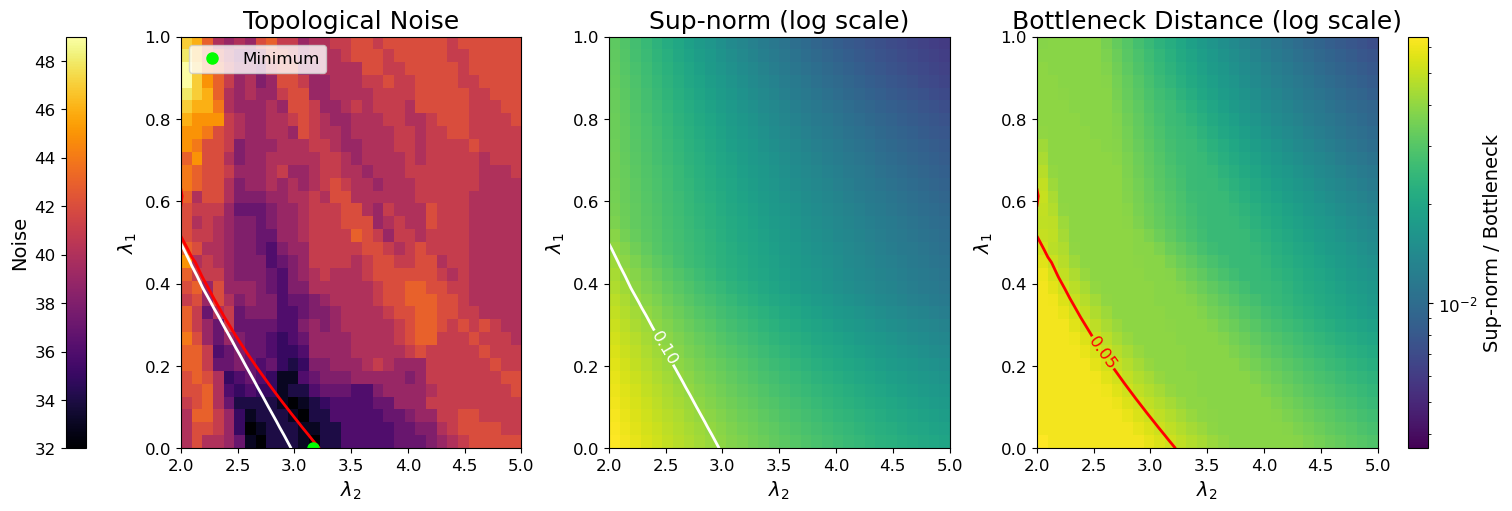

In [15]:

for name in names:
    print("-------------------------------------")
    print("-------------------------------------")
    print("-------------------------------------")
    print(f"RESULTS FOR {name}:\n")
    print("Minimum topological noise:", methods_results[name]["min_noise"])
    print("Sup-norm at minimum:", methods_results[name]["sup_norm_at_min"])
    print("Bottleneck at minimum:", methods_results[name]["bottleneck_at_min"])
    print("Parameter at minimum:", methods_results[name]["best_param"])
    if SAVE_PLOTS:
        save_plot_as = PLOTS_DIR + f"{name}.pdf"
    else:
        save_plot_as = None
    plot_results_2_parameters(
        methods_results,
        epsilon=0.1,
        save_plot_as=save_plot_as,
        full_name=name
    )

## Table of all results from low-pass filters

In [16]:
""" Printing all results in a table format using pandas DataFrame.
"""
import pandas as pd

# Create a list of selected result keys
selected_keys = ["min_noise", "sup_norm_at_min", "bottleneck_at_min", "best_param"]

# Extract the values for each method
table_data = {
    method: {key: methods_results[method][key] for key in selected_keys}
    for method in methods_results
}

# Convert to a DataFrame
df = pd.DataFrame.from_dict(table_data, orient='index')

# Optionally, sort by min_noise or another column
df = df.sort_values(by='min_noise')

# Print the DataFrame
df


min_noise  sup_norm_at_min  \
raised_cosine_non_normalized_gaussian          17     8.674971e-02   
ideal_low_pass_non_normalized_gaussian         17     8.535253e-02   
rational_non_normalized_gaussian               19     9.774110e-02   
lorentzian_non_normalized_gaussian             20     9.022520e-02   
heat_non_normalized_gaussian                   21     9.515982e-02   
power_non_normalized_gaussian                  23     9.819334e-02   
tikhonov_non_normalized_gaussian               25     9.821820e-02   
rational_normalized_gaussian                   32     9.659653e-02   
lorentzian_normalized_gaussian                 32     9.921767e-02   
raised_cosine_normalized_gaussian              32     8.934582e-02   
heat_normalized_gaussian                       34     9.524393e-02   
tikhonov_normalized_gaussian                   35     9.704988e-02   
tikhonov_normalized_uniform                    36     9.013131e-02   
power_normalized_gaussian                      36     9.873110e-02   
power_non_normalized_uniform                   36     6.610817e-02   
power_normalized_uniform                       36     9.094995e-02   
tikhonov_non_normalized_uniform                37     5.517338e-02   
rational_non_normalized_uniform                37     9.946960e-02   
lorentzian_non_normalized_uniform              37     9.770385e-02   
raised_cosine_non_normalized_uniform           37     9.832240e-02   
heat_normalized_uniform                        37     8.439242e-02   
heat_non_normalized_uniform                    37     5.739825e-02   
raised_cosine_normalized_uniform               38     9.873415e-02   
lorentzian_normalized_uniform                  39     9.080937e-02   
rational_normalized_uniform                    39     9.671686e-02   
ideal_low_pass_normalized_uniform              40     6.700872e-08   
ideal_low_pass_non_normalized_uniform          40     2.513433e-04   
ideal_low_pass_normalized_gaussian             43     6.811878e-04   

                                        bottleneck_at_min  \
raised_cosine_non_normalized_gaussian        7.577766e-02   
ideal_low_pass_non_normalized_gaussian       7.557269e-02   
rational_non_normalized_gaussian             7.150943e-02   
lorentzian_non_normalized_gaussian           6.590819e-02   
heat_non_normalized_gaussian                 7.465194e-02   
power_non_normalized_gaussian                8.728942e-02   
tikhonov_non_normalized_gaussian             8.810693e-02   
rational_normalized_gaussian                 5.572938e-02   
lorentzian_normalized_gaussian               5.724621e-02   
raised_cosine_normalized_gaussian            5.171110e-02   
heat_normalized_gaussian                     6.166291e-02   
tikhonov_normalized_gaussian                 6.166291e-02   
tikhonov_normalized_uniform                  8.930747e-02   
power_normalized_gaussian                    6.166291e-02   
power_non_normalized_uniform                 6.345373e-02   
power_normalized_uniform                     8.954840e-02   
tikhonov_non_normalized_uniform              5.468338e-02   
rational_non_normalized_uniform              9.946960e-02   
lorentzian_non_normalized_uniform            9.770385e-02   
raised_cosine_non_normalized_uniform         9.646835e-02   
heat_normalized_uniform                      8.365650e-02   
heat_non_normalized_uniform                  5.681161e-02   
raised_cosine_normalized_uniform             8.407698e-02   
lorentzian_normalized_uniform                8.717440e-02   
rational_normalized_uniform                  9.422672e-02   
ideal_low_pass_normalized_uniform            6.700872e-08   
ideal_low_pass_non_normalized_uniform        2.513433e-04   
ideal_low_pass_normalized_gaussian           6.799308e-04   

                                                                      best_param  
raised_cosine_non_normalized_gaussian   (1.3548387096774193, 1.5483870967741935)  
ideal_low_pass_non_normalized_gaussian                                  1

# High pass filters

In [17]:
def optimize_high_pass_filter_topological_noise(
    method, param_range, image, epsilon=0.1, k=100,
    normalized=False, gaussian_weights=False, sigma=0.1,
):
    """
    Evaluate topological noise under a given high-pass spectral filter and find optimal parameters.
    """
    # Step 1: Precompute Laplacian and eigendecomposition
    L, signal, H, W = image_to_graph(
        image,
        normalized=normalized,
        gaussian_weights=gaussian_weights,
        sigma=sigma
    )
    vals, vecs = eigsh(L, k=k, which='SM')
    original_diag = compute_diagram(image)
    _, relevant_original = count_small_and_big_intervals(original_diag, epsilon)

    # Step 2: Prepare storage for results
    min_noise = None
    relevant_killed = None
    best_param = None
    sup_norm_at_min = None
    bottleneck_at_min = None
    history_param, history_noise, history_sup, history_bottleneck, history_relevant = [], [], [], [], []

    # Step 3: Try each filter parameter
    for param in param_range:
        # Define transfer function h(lambda)
        if method == "complement_heat":
            h = lambda l: 1 - np.exp(-param * l)
        elif method == "ideal_hpf":
            h = lambda l: (l >= param).astype(float)
        elif method == "filter_0":
            h = lambda l: (l > 0).astype(float)
        elif method == "power_high":
            h = lambda l: l**param / (1 + l**param)
        elif method == "high_pass_bump":
            mu, sigma_bump = param
            h = lambda l: np.exp(-((l - mu) ** 2) / (2 * sigma_bump ** 2))
        else:
            raise ValueError(f"Unknown method: {method}")

        # Apply filter in spectral domain
        h_vals = h(vals)
        filtered = vecs @ (h_vals * (vecs.T @ signal))
        filtered_img = filtered.reshape(H, W)

        # Evaluate
        sup_norm = np.max(np.abs(filtered_img - image))
        diag = compute_diagram(filtered_img)
        noise, relevant = count_small_and_big_intervals(diag, epsilon)
        bottleneck = bottleneck_distance(original_diag, diag)

        # Track results
        history_param.append(param)
        history_noise.append(noise)
        history_sup.append(sup_norm)
        history_bottleneck.append(bottleneck)
        history_relevant.append(relevant)

        if sup_norm <= epsilon:
            if min_noise is None or noise < min_noise:
                min_noise = noise
                relevant_killed = relevant_original - relevant
                best_param = param
                sup_norm_at_min = sup_norm
                bottleneck_at_min = bottleneck

    return min_noise, relevant_killed, sup_norm_at_min, bottleneck_at_min, best_param, history_param, history_noise, history_sup, history_bottleneck, history_relevant

In [18]:
from skimage import data, color
from skimage.transform import resize
import numpy as np

name = "ideal_hpf_non_normalized_gaussian"
names = [name]

# Load and preprocess image
image = color.rgb2gray(data.astronaut())
image = resize(image, (24, 24), anti_aliasing=True)

# Define parameter range for tau in complement heat kernel
params = np.concatenate((np.array([0]), np.linspace(0.00001, 10, 30)))

# Run the analysis
result = optimize_high_pass_filter_topological_noise(
    method="ideal_hpf",
    param_range=params,
    image=image,
    epsilon=0.1,
    k=575,
    normalized=False,
    gaussian_weights=True,
    sigma=sigma
)

methods_results[name] = {
        "min_noise": result[0],
        "relevant_killed": result[1],
        "sup_norm_at_min": result[2],
        "bottleneck_at_min": result[3],
        "best_param": result[4],
        "history_param": result[5],
        "history_noise": result[6],
        "history_sup": result[7],
        "history_bottleneck": result[8],
        "history_relevant": result[9],
    }


-------------------------------------
-------------------------------------
-------------------------------------
RESULTS FOR ideal_hpf_non_normalized_gaussian:

Minimum topological noise: 40
Sup-norm at minimum: 0.001184758031518185
Bottleneck at minimum: 0.0010986360801450434
Parameter at minimum: 0.0
Plotting ideal_hpf_non_normalized_gaussian


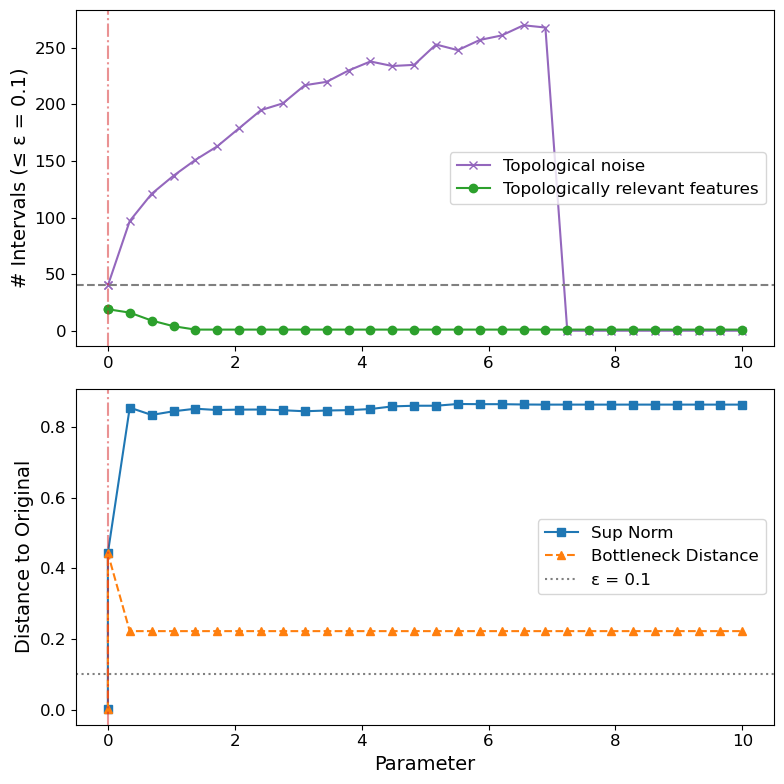

In [19]:
for name in names:
    print("-------------------------------------")
    print("-------------------------------------")
    print("-------------------------------------")
    print(f"RESULTS FOR {name}:\n")
    print("Minimum topological noise:", methods_results[name]["min_noise"])
    print("Sup-norm at minimum:", methods_results[name]["sup_norm_at_min"])
    print("Bottleneck at minimum:", methods_results[name]["bottleneck_at_min"])
    print("Parameter at minimum:", methods_results[name]["best_param"])
    if SAVE_PLOTS:
        save_plot_as = PLOTS_DIR + f"{name}.pdf"
    else:
        save_plot_as = None
    plot_results(
        methods_results,
        epsilon=epsilon,
        full_name=name,
        save_plot_as=save_plot_as,
    )

# Band-pass

In [20]:
def optimize_band_pass_filter_topological_noise(
    method, param_range, image, epsilon=0.1, k=100,
    normalized=False, gaussian_weights=False, sigma=0.1,
):
    """
    Evaluate topological noise under a band-pass spectral filter and find optimal parameters.
    """
    # Step 1: Precompute Laplacian and eigendecomposition
    L, signal, H, W = image_to_graph(
        image,
        normalized=normalized,
        gaussian_weights=gaussian_weights,
        sigma=sigma
    )
    vals, vecs = eigsh(L, k=k, which='SM')
    original_diag = compute_diagram(image)
    _, relevant_original = count_small_and_big_intervals(original_diag, epsilon)

    # Step 2: Prepare storage for results
    min_noise = None
    relevant_killed = None
    best_param = None
    sup_norm_at_min = None
    bottleneck_at_min = None
    history_param, history_noise, history_sup, history_bottleneck, history_relevant = [], [], [], [], []

    # Step 3: Try each filter parameter
    for param in param_range:
        # Define transfer function h(lambda)
        if method == "ideal_bpf":
            a, b = param
            h = lambda l: ((l >= a) & (l <= b)).astype(float)
        elif method == "raised_cosine_bpf":
            a, b = param
            def raised_cosine(l):
                h_val = np.zeros_like(l)
                mask = (l >= a) & (l <= b)
                h_val[mask] = 0.5 * (1 + np.cos(np.pi * (l[mask] - a) / (b - a)))
                return h_val
            h = raised_cosine
        elif method == "gabor_bpf":
            mu, sigma_bump = param
            h = lambda l: np.exp(-((l - mu) ** 2) / (2 * sigma_bump ** 2))
        else:
            raise ValueError(f"Unknown method: {method}")

        # Apply filter in spectral domain
        h_vals = h(vals)
        filtered = vecs @ (h_vals * (vecs.T @ signal))
        filtered_img = filtered.reshape(H, W)

        # Evaluate
        sup_norm = np.max(np.abs(filtered_img - image))
        diag = compute_diagram(filtered_img)
        noise, relevant = count_small_and_big_intervals(diag, epsilon)
        bottleneck = bottleneck_distance(original_diag, diag)

        # Track results
        history_param.append(param)
        history_noise.append(noise)
        history_sup.append(sup_norm)
        history_bottleneck.append(bottleneck)
        history_relevant.append(relevant)

        if sup_norm <= epsilon:
            if min_noise is None or noise < min_noise:
                min_noise = noise
                relevant_killed = relevant_original - relevant
                best_param = param
                sup_norm_at_min = sup_norm
                bottleneck_at_min = bottleneck

    return min_noise, relevant_killed, sup_norm_at_min, bottleneck_at_min, best_param, history_param, history_noise, history_sup, history_bottleneck, history_relevant

In [21]:
name = "ideal_bpf_non_normalized_gaussian"
names = [name]
normalized = False
gaussian_weights = True

# Load and preprocess image
image = color.rgb2gray(data.astronaut())
image = resize(image, (24, 24), anti_aliasing=True)

# Define parameter range for tau in complement heat kernel
res = 32
params = [(a, b) for a in np.linspace(-1e-5, 0.001, res) for b in np.linspace(0.0, 10, res) if a < b]

# Run the analysis
result = optimize_band_pass_filter_topological_noise(
    method="ideal_bpf",
    param_range=params,
    image=image,
    epsilon=epsilon,
    k=575,
    normalized=normalized,
    gaussian_weights=gaussian_weights,
    sigma=sigma
)

methods_results[name] = {
        "min_noise": result[0],
        "relevant_killed": result[1],
        "sup_norm_at_min": result[2],
        "bottleneck_at_min": result[3],
        "best_param": result[4],
        "history_param": result[5],
        "history_noise": result[6],
        "history_sup": result[7],
        "history_bottleneck": result[8],
        "history_relevant": result[9],
    }


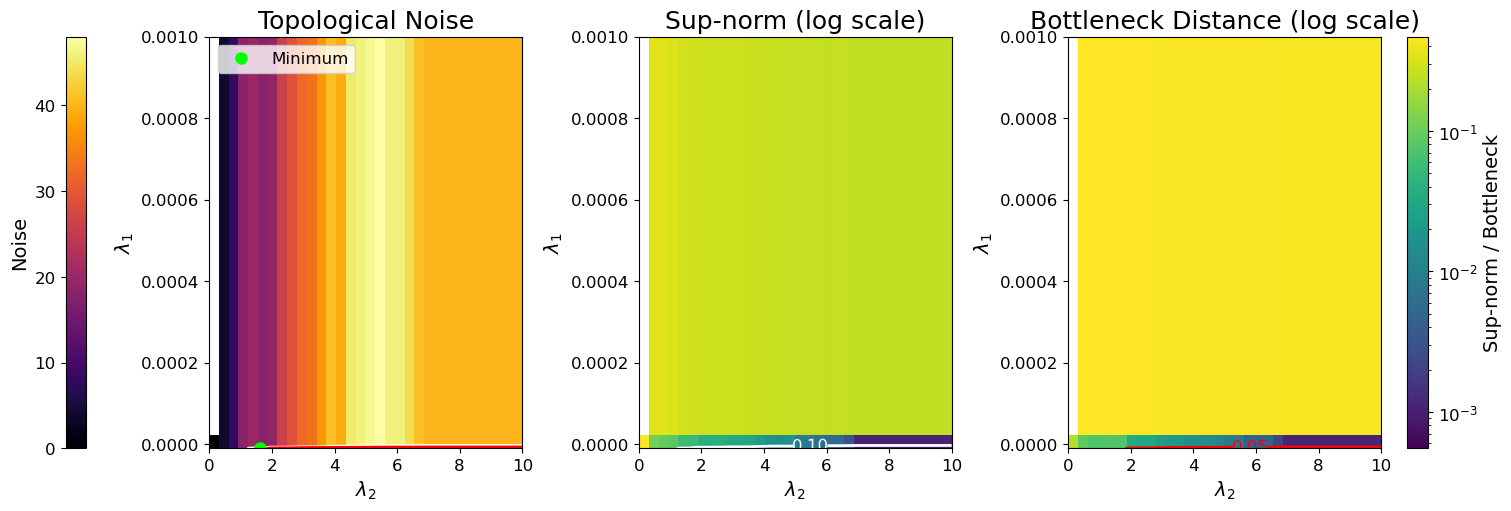

In [22]:
if SAVE_PLOTS:
    save_plot_as = PLOTS_DIR + f"{name}.pdf"
else:
    save_plot_as = None
plot_results_2_parameters(methods_results, epsilon=epsilon, save_plot_as=save_plot_as, full_name=name)

In the plot above, we observe that for any $\lambda_1 > 0$, the constant eigenfunction is entirely removed by the band-pass filter, which only retains eigenvalues in the range $[\lambda_1, \lambda_2]$. As a result, the filtered signal differs significantly from the original, leading to a large sup-norm error. This explains why the contour line corresponding to a sup-norm of 0.1 lies along the $x$-axis: the exclusion of the constant eigenfunction causes an abrupt change in the reconstructed signal.

# Low and band-pass Composite

In [23]:
def optimize_low_band_composite_filter_topological_noise(
    method, param_range, image, epsilon=0.1, k=100,
    normalized=False, gaussian_weights=False, sigma=0.1,
):
    """
    Evaluate topological noise under a composite low-band spectral filter and find optimal parameters.

    Supported methods:
        - "ideal_composite": passes [0,a] ∪ [b,c]
        - "raised_cosine_composite": smooth transitions in both [0,a] and [b,c]

    Parameters:
        param_range: list of (a, b, c) tuples
    """
    # Step 1: Precompute Laplacian and eigendecomposition
    L, signal, H, W = image_to_graph(
        image,
        normalized=normalized,
        gaussian_weights=gaussian_weights,
        sigma=sigma
    )
    vals, vecs = eigsh(L, k=k, which='SM')
    original_diag = compute_diagram(image)
    _, relevant_original = count_small_and_big_intervals(original_diag, epsilon)

    # Step 2: Initialize result trackers
    min_noise = None
    relevant_killed = None
    best_param = None
    sup_norm_at_min = None
    bottleneck_at_min = None
    history_param, history_noise, history_sup, history_bottleneck, history_relevant = [], [], [], [], []

    # Step 3: Sweep through parameters
    for param in param_range:
        a, b, c = param
        band1_start, band1_end = -1e-4, a
        band2_start, band2_end = a + b, a + b + c

        if method == "ideal_composite":
            h = lambda l: ((l >= band1_start) & (l <= band1_end) | 
                           (l >= band2_start) & (l <= band2_end)).astype(float)

        elif method == "raised_cosine_composite":
            def raised_cosine_composite(l):
                h_val = np.zeros_like(l)

                # First band: raised cosine falloff between a - delta and a
                delta1 = b / 2  # use b to control smooth transition gap
                mask1 = (l >= band1_start) & (l <= band1_end)
                h_val[mask1] = 1.0
                # (optional: you can add a falloff for smooth transition at end of first band)

                # Second band: raised cosine rise and fall
                delta2 = c / 2
                start2, end2 = band2_start, band2_end
                mask2 = (l >= start2) & (l <= end2)
                h_val[mask2] = 0.5 * (1 + np.cos(np.pi * (l[mask2] - start2) / (end2 - start2)))

                return h_val
            h = raised_cosine_composite

        else:
            raise ValueError(f"Unknown method: {method}")


        # Apply filter
        h_vals = h(vals)
        filtered = vecs @ (h_vals * (vecs.T @ signal))
        filtered_img = filtered.reshape(H, W)

        # Evaluate
        sup_norm = np.max(np.abs(filtered_img - image))
        diag = compute_diagram(filtered_img)
        noise, relevant = count_small_and_big_intervals(diag, epsilon)
        bottleneck = bottleneck_distance(original_diag, diag)

        # Track results
        history_param.append(param)
        history_noise.append(noise)
        history_sup.append(sup_norm)
        history_bottleneck.append(bottleneck)
        history_relevant.append(relevant)

        if sup_norm <= epsilon:
            if min_noise is None or noise < min_noise:
                min_noise = noise
                relevant_killed = relevant_original - relevant
                best_param = param
                sup_norm_at_min = sup_norm
                bottleneck_at_min = bottleneck

    return min_noise, relevant_killed, sup_norm_at_min, bottleneck_at_min, best_param, history_param, history_noise, history_sup, history_bottleneck, history_relevant


In [24]:
name = "ideal_composite_non_normalized_gaussian"
names = [name]

image = color.rgb2gray(data.astronaut())
image = resize(image, (24, 24))

res = 16
params = [(a,b,c) for a in np.linspace(0.0001, 3, res) for b in np.linspace(0.0, 4, res) for c in np.linspace(0.0, 4, res)]
result = optimize_low_band_composite_filter_topological_noise(
    method="ideal_composite",
    param_range=params,
    image=image,
    epsilon=epsilon,
    k=575,
    normalized=False,
    gaussian_weights=True,
    sigma=sigma
)

methods_results[name] = {
        "min_noise": result[0],
        "relevant_killed": result[1],
        "sup_norm_at_min": result[2],
        "bottleneck_at_min": result[3],
        "best_param": result[4],
        "history_param": result[5],
        "history_noise": result[6],
        "history_sup": result[7],
        "history_bottleneck": result[8],
        "history_relevant": result[9],
    }

In [25]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogLocator, LogFormatter

def plot_results_3_params(
    methods_results, epsilon=0.1, save_plot_as=None, full_name="", plot_only_sup_norm_below=None,
    plot = "noise", log_scale=False
):
    """ Plot results from `optimize_low_band_composite_filter_topological_noise`.
    Parameters
    ----------
    methods_results : dict
        Dictionary containing results from the optimization function.
    epsilon : float
        Sup-norm threshold for epsilon-approximation.
    save_plot_as : str or None
        If provided, saves the plot to this filename.
    full_name : str
        Name of the method to plot results for.
    plot_only_sup_norm_below : float or None
        If provided, only plots results where sup-norm is below this value.
    plot : str
        Specifies which metric to plot: "noise", "relevant" (relevant topological features), "sup" (sup-norm), or "bottleneck".
    """

    history_param = np.array(methods_results[full_name]["history_param"])
    history_plot = np.array(methods_results[full_name][f"history_{plot}"])
    history_sup = np.array(methods_results[full_name]["history_sup"])

    if plot_only_sup_norm_below is not None:
        mask = history_sup <= plot_only_sup_norm_below
        history_param = history_param[mask]
        history_plot = history_plot[mask]

    # Coordinates for 3D plot
    x = history_param[:, 0]
    y = history_param[:, 1]
    z = history_param[:, 2]
    c = history_plot

    # Choose colormap normalization
    if log_scale:
        norm = LogNorm(vmin=np.min(c[c > 0]), vmax=np.max(c))
    else:
        norm = None

    # Create 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Transparent scatter plot
    sc = ax.scatter(x, y, z, c=c, cmap='viridis', alpha=0.8, s=50, norm=norm)

    # Set specific x-axis ticks
    ax.set_xticks([0.5, 1.0, 1.5])

    # Add colorbar
    cbar = plt.colorbar(sc, ax=ax, label='Topological Noise', shrink=0.7, pad=0.15)

    if log_scale:
        cbar.locator = LogLocator(base=10.0, subs=(1.0,), numticks=10)
        cbar.formatter = LogFormatter(base=10.0, labelOnlyBase=True)
        cbar.update_ticks()

    # Set axis labels
    ax.set_xlabel('$\lambda_1$')
    ax.set_ylabel('$\lambda_2$')
    ax.set_zlabel('$\lambda_3$')

    if save_plot_as is not None:
        plt.savefig(save_plot_as, bbox_inches='tight')
    plt.show()

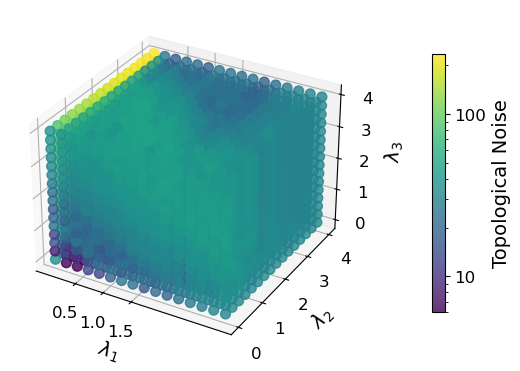

In [26]:
name = "ideal_composite_non_normalized_gaussian"
if SAVE_PLOTS:
    save_plot_as = PLOTS_DIR + f"{name}_full.pdf"
else:
    save_plot_as = None
plot_results_3_params(
    methods_results,
    epsilon=epsilon,
    save_plot_as=save_plot_as,
    full_name=name,
    log_scale=True
)

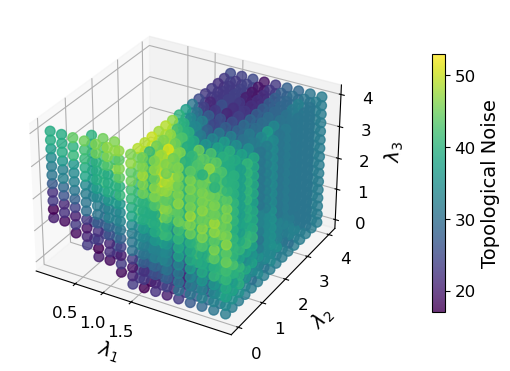

In [27]:
below = 0.1  # Sup-norm threshold for filtering results
if SAVE_PLOTS:
    save_plot_as = PLOTS_DIR + f"{name}_below_{str(below).strip(".")}.pdf"
else:
    save_plot_as = None

plot_results_3_params(
    methods_results,
    epsilon=epsilon,
    save_plot_as=save_plot_as,
    full_name=name,
    plot_only_sup_norm_below=below,
    plot="noise",
    log_scale=False
)

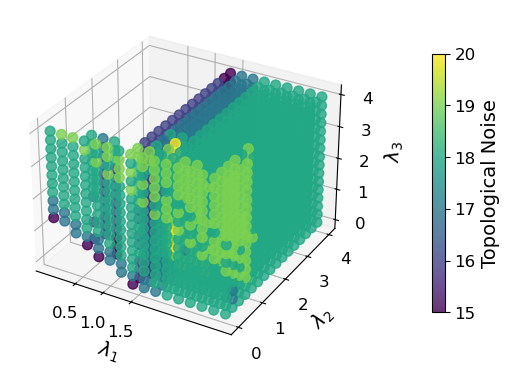

In [28]:
below = 0.1  # Sup-norm threshold for filtering results
plot = "relevant"  # Specify which metric to plot: "noise", "relevant", "sup", or "bottleneck"
if SAVE_PLOTS:
    save_plot_as = PLOTS_DIR + f"{name}_below_{str(below).strip(".")}_{plot}.pdf"
else:
    save_plot_as = None

plot_results_3_params(
    methods_results,
    epsilon=epsilon,
    save_plot_as=None,
    full_name=name,
    plot_only_sup_norm_below=below,
    plot=plot
)

# Digital Signal Processing Denoising Techniques

## Gaussian Blur

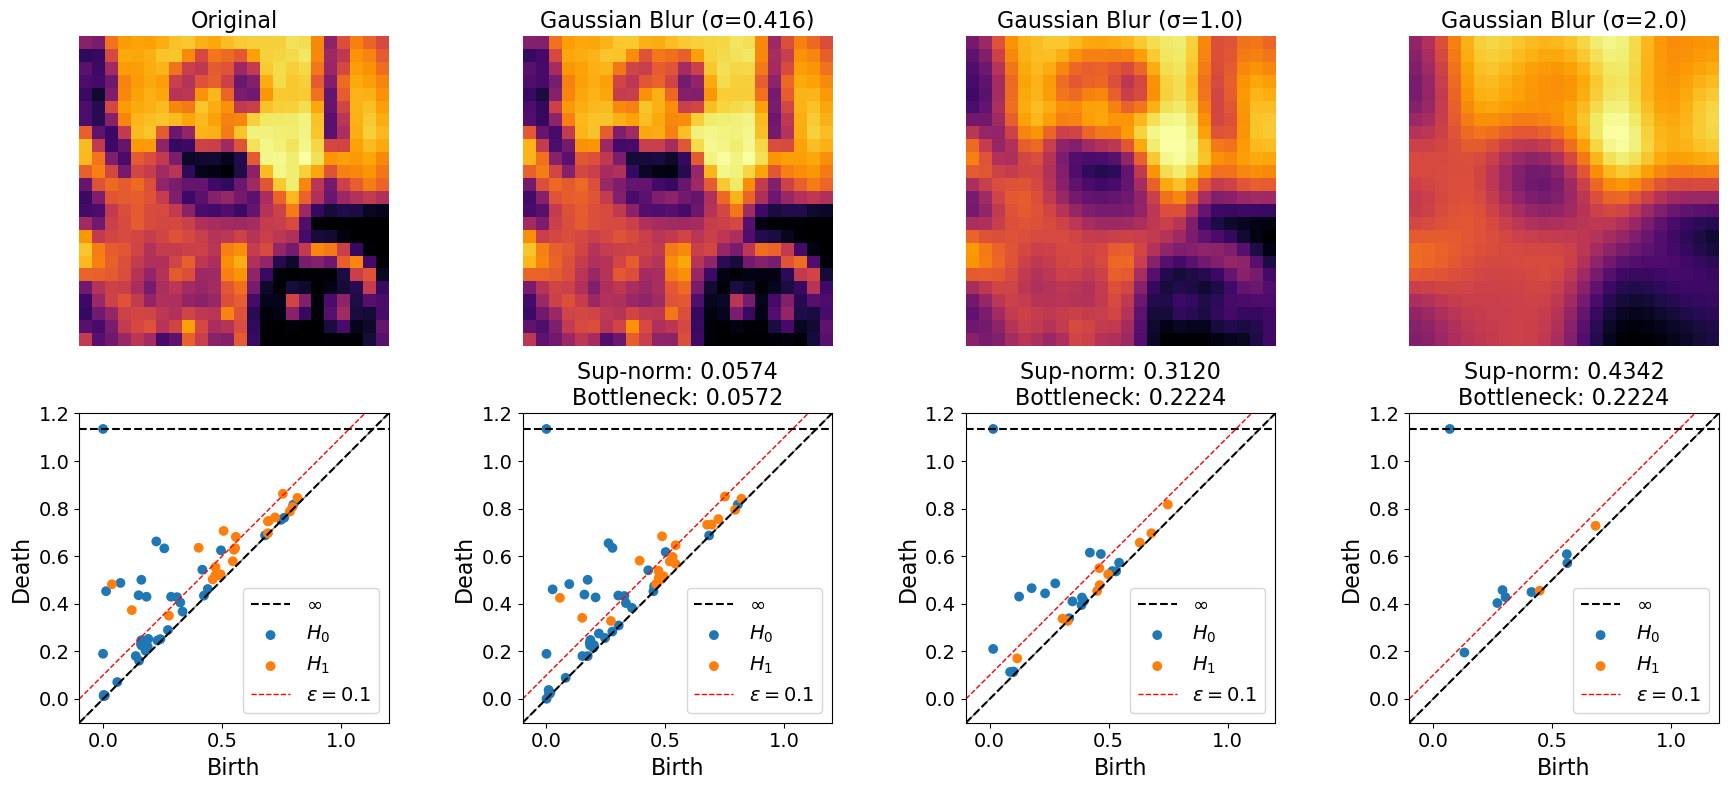

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, color, filters
from skimage.transform import resize
import cripser
import persim
from scipy.ndimage import gaussian_filter

# Plot settings
plt.rcdefaults()
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('legend', fontsize=12)
plt.rc('font', size=12)

def compute_diagram(img):
    ph = cripser.computePH(img)
    return [ph[ph[:, 0] == d, 1:3] for d in range(2)]

def gaussian_blur_filter(img, sigma):
    return gaussian_filter(img, sigma=sigma)

# Load and resize image
image = color.rgb2gray(data.astronaut())
image = resize(image, (24, 24), anti_aliasing=True)

# Apply filters
filtered_images = {
    "Original": image,
    "Gaussian Blur (σ=0.416)": gaussian_blur_filter(image, sigma=0.416),
    "Gaussian Blur (σ=1.0)": gaussian_blur_filter(image, sigma=1.0),
    "Gaussian Blur (σ=2.0)": gaussian_blur_filter(image, sigma=2.0),
}

# Compute persistence diagrams
diagrams = {name: compute_diagram(img) for name, img in filtered_images.items()}
original_dgm = diagrams["Original"]

# Plotting
titlesize = 16
eps = 0.1
fig, axes = plt.subplots(2, 4, figsize=(18, 8))
for i, (name, img) in enumerate(filtered_images.items()):
    axes[0, i].imshow(img, cmap='inferno')
    axes[0, i].set_title(name, fontsize=titlesize)
    axes[0, i].axis('off')

    # Plot persistence diagram
    persim.plot_diagrams(diagrams[name], ax=axes[1, i], size=50, xy_range=[-0.1, 1.2, -0.1, 1.2])
    x_vals = np.linspace(-0.1, 1.2, 100)
    axes[1, i].plot(x_vals, x_vals + eps, 'r--', linewidth=1, label=f'$\\varepsilon = {eps}$')
    axes[1, i].plot(x_vals, x_vals, 'k--', linewidth=1, alpha=0.5)

    # Compute bottleneck and sup-norm distances
    if name != "Original":
        sup_norm = np.max(np.abs(image - img))
        b0 = persim.bottleneck(original_dgm[0], diagrams[name][0])
        b1 = persim.bottleneck(original_dgm[1], diagrams[name][1])
        bdist = max(b0, b1)
        axes[1, i].set_title(f"Sup-norm: {sup_norm:.4f}\nBottleneck: {bdist:.4f}", fontsize=titlesize)

    axes[1, i].set_xlabel("Birth", fontsize=16)
    axes[1, i].set_ylabel("Death", fontsize=16)
    axes[1, i].tick_params(axis='both', labelsize=14)
    axes[1, i].legend(fontsize=14)

plt.tight_layout()
if SAVE_PLOTS:
    plt.savefig(PLOTS_DIR + "astr-gaussian-blur.png", dpi=300, bbox_inches='tight')
plt.show()


In [30]:
from scipy.ndimage import gaussian_filter
from scipy.signal import medfilt2d, wiener
from skimage.restoration import (
    denoise_tv_chambolle,
    denoise_nl_means,
    denoise_wavelet,
    estimate_sigma,
    denoise_tv_bregman,
)
import pywt
import cv2


def apply_denoising(image, method, param):
    if method == "gaussian":
        return gaussian_filter(image, sigma=param)
    elif method == "median":
        return medfilt2d(image, kernel_size=int(param))
    elif method == "tv":
        return denoise_tv_chambolle(image, weight=1/param)
    elif method == "tv_bregman":
        return denoise_tv_bregman(image, weight=param, eps=1e-6)
    elif method == "nlm":
        sigma_est = np.mean(estimate_sigma(image, channel_axis=None))
        return denoise_nl_means(image, h=param * sigma_est, fast_mode=True,
                                patch_size=3, patch_distance=5, channel_axis=None)
    elif method == "bilateral":
        import cv2
        return cv2.bilateralFilter((image * 255).astype(np.uint8),
                                   d=9, sigmaColor=param, sigmaSpace=param) / 255.0
    elif method == "wiener":
        return wiener(image, mysize=5, noise=param)
    elif method == "wavelet":
        return denoise_wavelet(image, method='BayesShrink', mode='soft',
                               rescale_sigma=True, sigma=param)
    elif method == "wavelet_raw":
        coeffs = pywt.wavedec2(image, 'db1', level=2)
        coeffs_thresh = [
            pywt.threshold(c, value=param, mode='soft') if isinstance(c, np.ndarray)
            else tuple(pywt.threshold(ci, param, 'soft') for ci in c)
            for c in coeffs
        ]
        return pywt.waverec2(coeffs_thresh, 'db1')
    elif method == "guided":
        import cv2
        return cv2.ximgproc.guidedFilter(guide=image, src=image,
                                          radius=5, eps=param)
    else:
        raise ValueError(f"Unknown method: {method}")
    


def optimize_denoising_topological_noise(
    method, param_range, image, epsilon=0.1
):
    """
    Optimize topological noise reduction using classical denoising methods.

    Supported methods:
        gaussian, median, tv, tv_bregman, nlm, bilateral,
        wiener, wavelet, wavelet_raw, guided
    """
    original_diag = compute_diagram(image)
    _, relevant_original = count_small_and_big_intervals(original_diag, epsilon)


    min_noise = None
    relevant_killed = None
    best_param = None
    sup_norm_at_min = None
    bottleneck_at_min = None

    history_param = []
    history_noise = []
    history_sup = []
    history_bottleneck = []
    history_relevant = []

    for param in param_range:
        try:
            filtered = apply_denoising(image, method=method, param=param)
        except Exception as e:
            print(f"Skipping param={param} due to error: {e}")
            continue

        sup_norm = np.max(np.abs(filtered - image))
        diag = compute_diagram(filtered)
        noise, relevant = count_small_and_big_intervals(diag, epsilon)
        bottleneck = bottleneck_distance(original_diag, diag)

        history_param.append(param)
        history_noise.append(noise)
        history_sup.append(sup_norm)
        history_bottleneck.append(bottleneck)
        history_relevant.append(relevant)

        if sup_norm <= epsilon:
            if min_noise is None or noise < min_noise:
                min_noise = noise
                relevant_killed = relevant_original - relevant
                best_param = param
                sup_norm_at_min = sup_norm
                bottleneck_at_min = bottleneck

    return min_noise, relevant_killed, sup_norm_at_min, bottleneck_at_min, best_param, history_param, history_noise, history_sup, history_bottleneck, history_relevant



In [31]:
res = 120
denoising_methods = {
    "gaussian": np.linspace(0.1, 3.0, res),
    "median": np.arange(3, 19, 2),
    "tv": np.linspace(0.1, 100, res),
    "nlm": np.linspace(0.1, 6.0, res),
    "bilateral": np.linspace(0, 50, res),
    "wiener": np.linspace(1e-7, 0.004, res),
    "wavelet": np.linspace(1e-5, 0.2, res),
    "wavelet_raw": np.linspace(1e-5, 0.2,res),
    "guided": np.linspace(1e-6, 4e-2, res),
}

In [32]:
# epsilon = 0.1
names = denoising_methods.keys()
# Select methods based on criteria to run the function: Standard setting runs for all methods which is equivalent to names = raised_cosine_dict.keys()
names = ["gaussian", "median", "tv", "nlm", "bilateral", "wiener", "wavelet", "wavelet_raw", "guided"]

img = color.rgb2gray(data.astronaut())
img = resize(img, (24, 24))
img = img.astype(np.float32)
img = img.copy()

for name in names:
    params = denoising_methods[name]

    result = optimize_denoising_topological_noise(
        method=name,
        param_range=params,
        image=img,
        epsilon=epsilon,
    )

    methods_results[name] = {
        "min_noise": result[0],
        "relevant_killed": result[1],
        "sup_norm_at_min": result[2],
        "bottleneck_at_min": result[3],
        "best_param": result[4],
        "history_param": result[5],
        "history_noise": result[6],
        "history_sup": result[7],
        "history_bottleneck": result[8],
        "history_relevant": result[9],
    }

-------------------------------------
-------------------------------------
-------------------------------------
RESULTS FOR gaussian:

Minimum topological noise: 37
Sup-norm at minimum: 0.05795163
Bottleneck at minimum: 0.05772167444229126
Parameter at minimum: 0.4168067226890756
Plotting gaussian


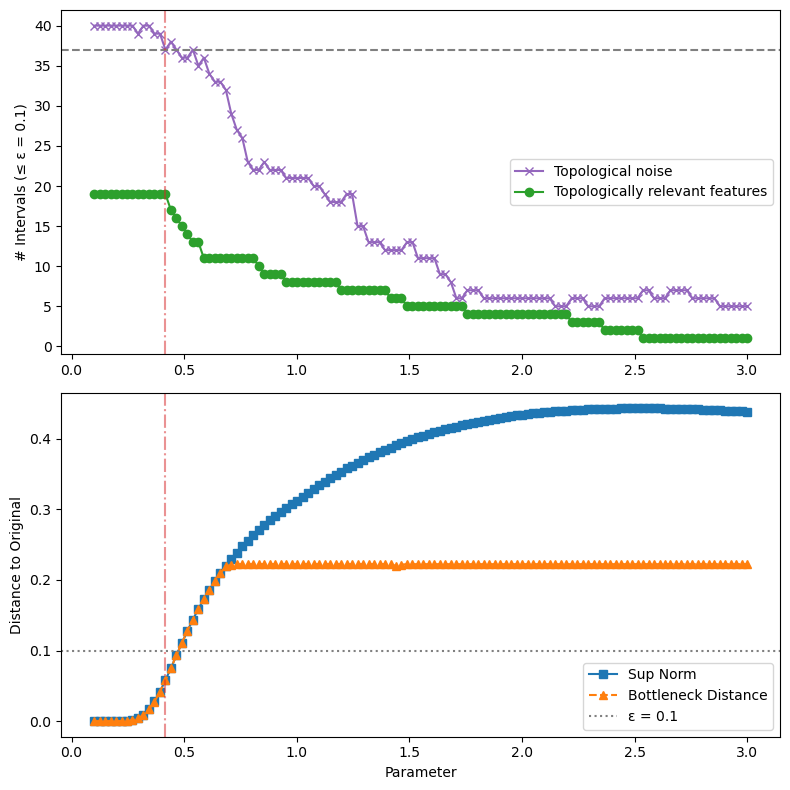

-------------------------------------
-------------------------------------
-------------------------------------
RESULTS FOR median:

Minimum topological noise: None
Sup-norm at minimum: None
Bottleneck at minimum: None
Parameter at minimum: None
Plotting median


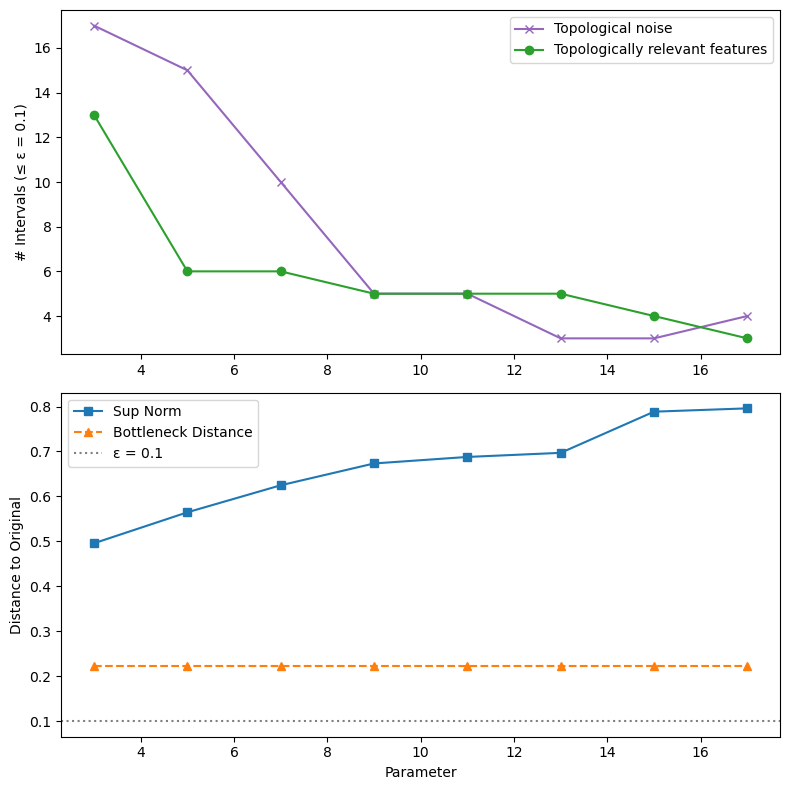

-------------------------------------
-------------------------------------
-------------------------------------
RESULTS FOR tv:

Minimum topological noise: 30
Sup-norm at minimum: 0.098825544
Bottleneck at minimum: 0.09882554411888123
Parameter at minimum: 34.51932773109244
Plotting tv


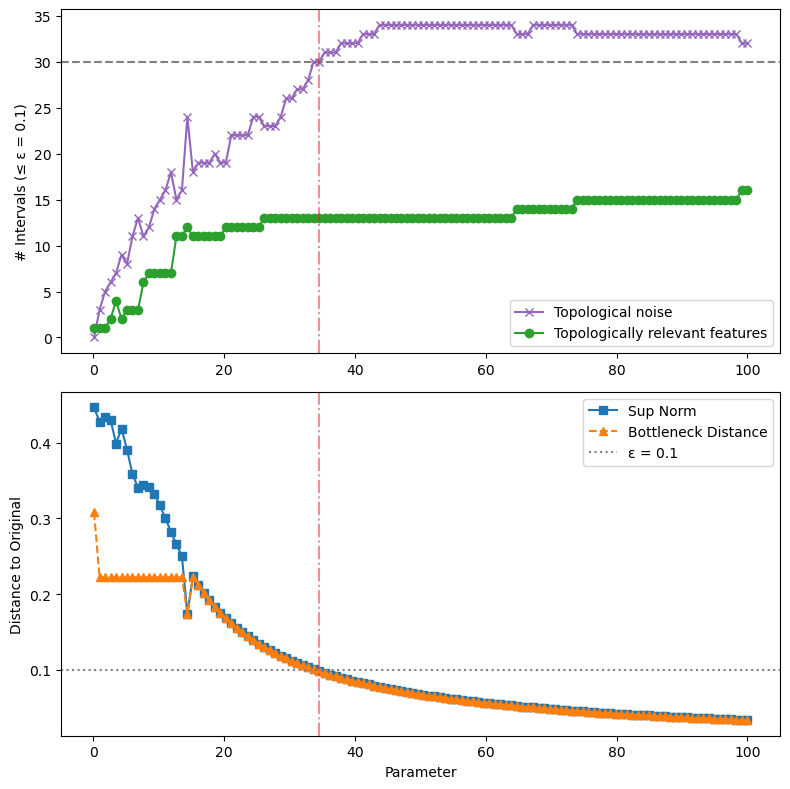

-------------------------------------
-------------------------------------
-------------------------------------
RESULTS FOR nlm:

Minimum topological noise: 39
Sup-norm at minimum: 0.013967156
Bottleneck at minimum: 0.009094774723052979
Parameter at minimum: 0.2983193277310925
Plotting nlm


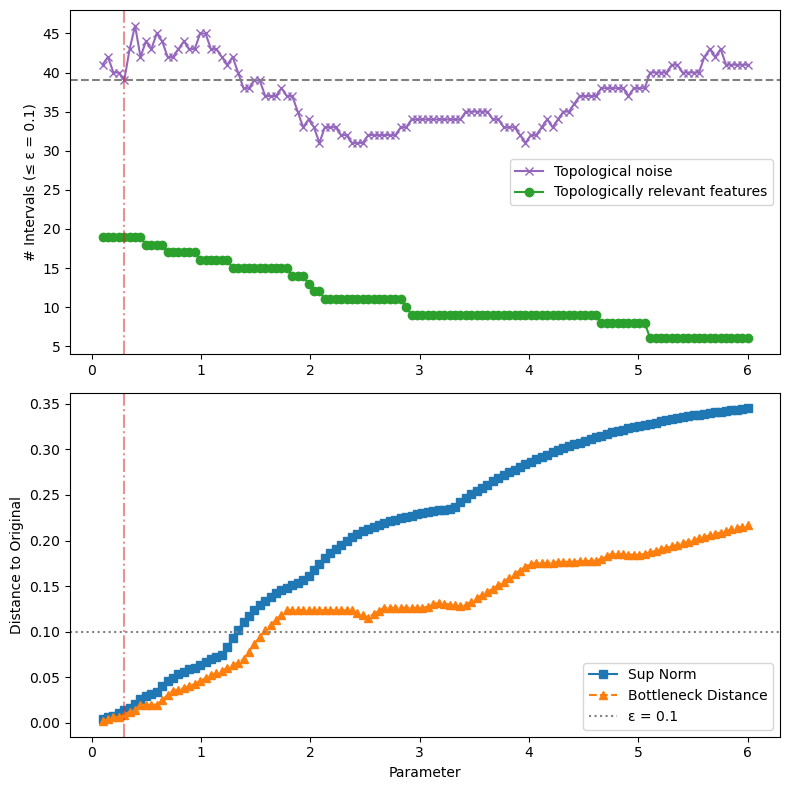

-------------------------------------
-------------------------------------
-------------------------------------
RESULTS FOR bilateral:

Minimum topological noise: 34
Sup-norm at minimum: 0.027267108244054428
Bottleneck at minimum: 0.027267108244054428
Parameter at minimum: 5.46218487394958
Plotting bilateral


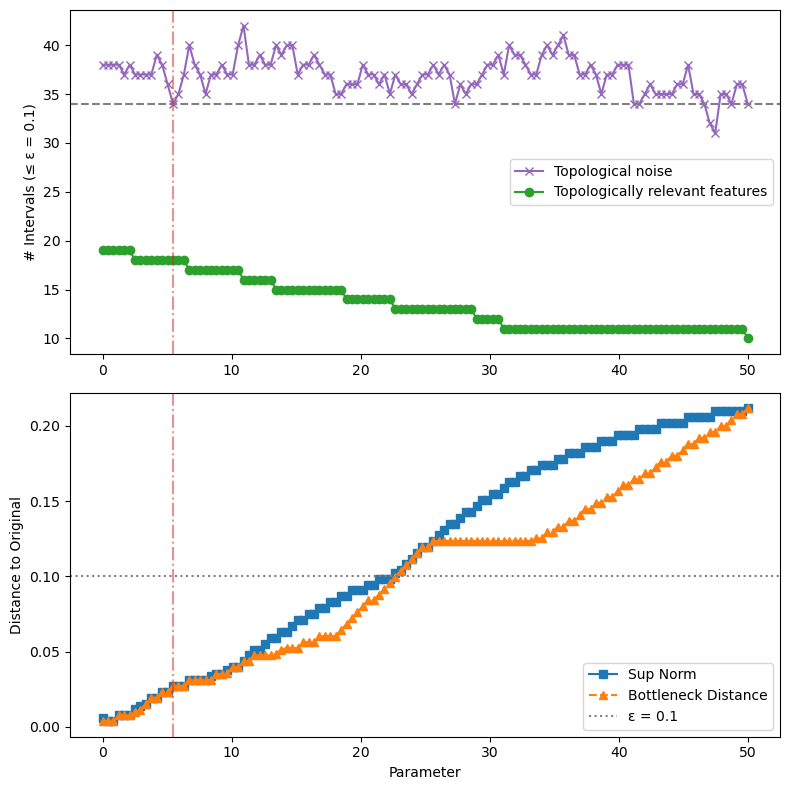

-------------------------------------
-------------------------------------
-------------------------------------
RESULTS FOR wiener:

Minimum topological noise: 40
Sup-norm at minimum: 4.226135884966009e-06
Bottleneck at minimum: 4.226135884966009e-06
Parameter at minimum: 1e-07
Plotting wiener


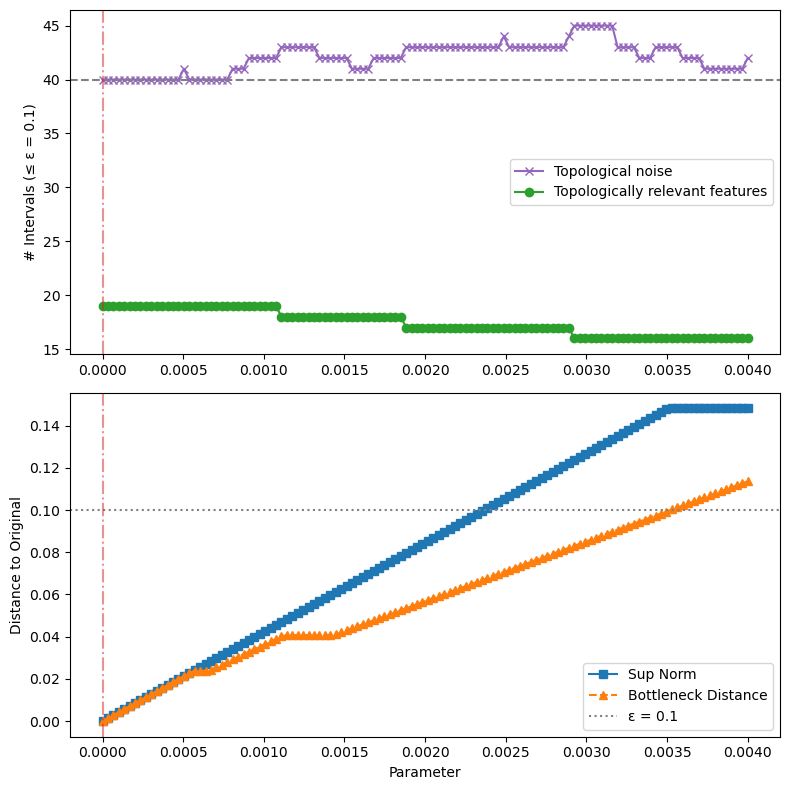

-------------------------------------
-------------------------------------
-------------------------------------
RESULTS FOR wavelet:

Minimum topological noise: 26
Sup-norm at minimum: 0.080984116
Bottleneck at minimum: 0.06379890441894531
Parameter at minimum: 0.048747058823529414
Plotting wavelet


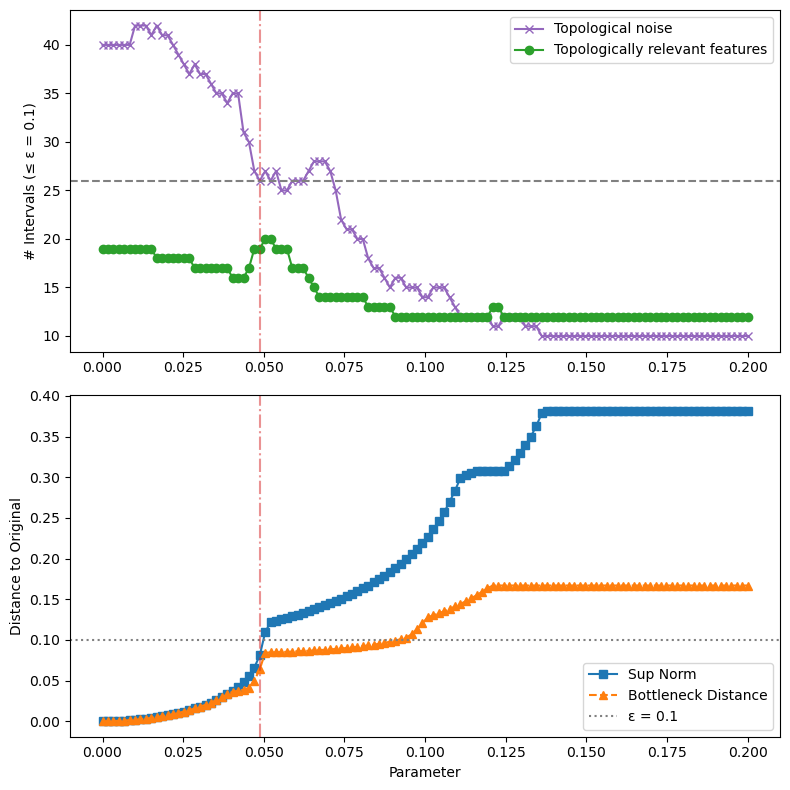

-------------------------------------
-------------------------------------
-------------------------------------
RESULTS FOR wavelet_raw:

Minimum topological noise: 32
Sup-norm at minimum: 0.0672487
Bottleneck at minimum: 0.061662912368774414
Parameter at minimum: 0.026899411764705883
Plotting wavelet_raw


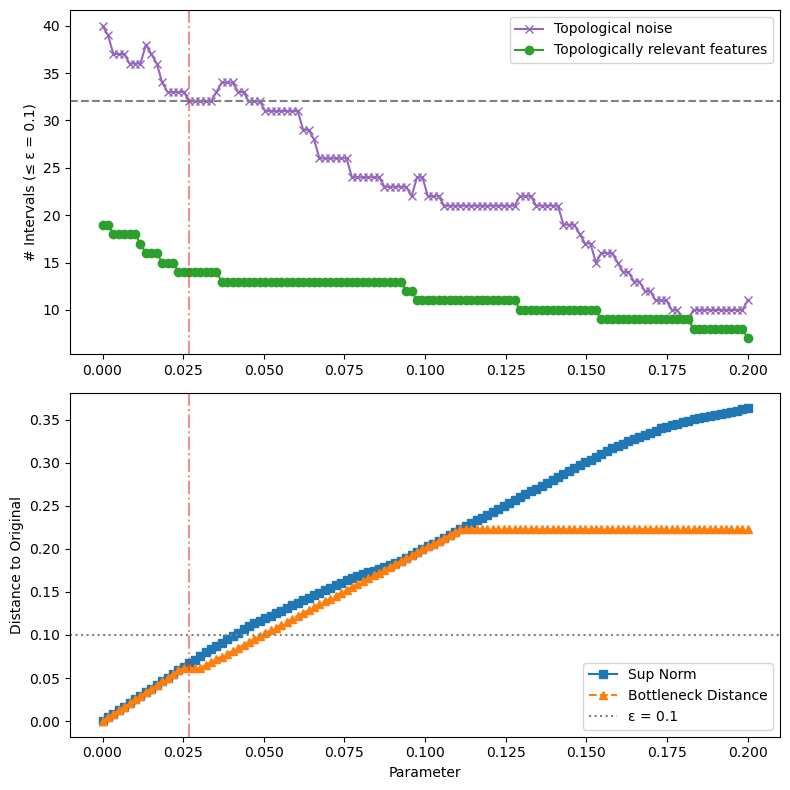

-------------------------------------
-------------------------------------
-------------------------------------
RESULTS FOR guided:

Minimum topological noise: 39
Sup-norm at minimum: 0.0199731
Bottleneck at minimum: 0.01952512562274933
Parameter at minimum: 0.0013455042016806721
Plotting guided


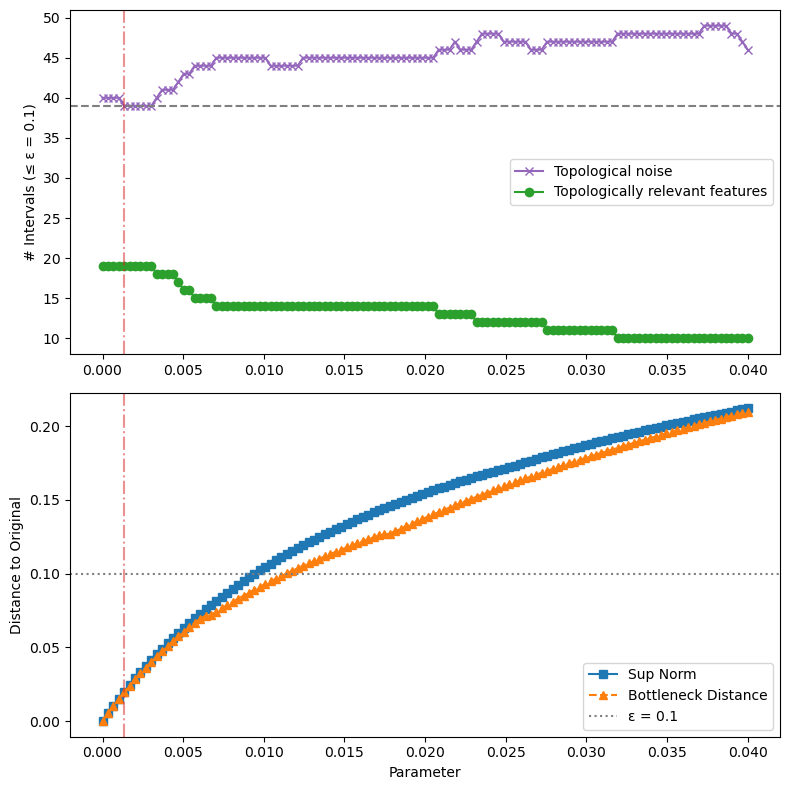

In [33]:
for name in names:
    print("-------------------------------------")
    print("-------------------------------------")
    print("-------------------------------------")
    print(f"RESULTS FOR {name}:\n")
    print("Minimum topological noise:", methods_results[name]["min_noise"])
    print("Sup-norm at minimum:", methods_results[name]["sup_norm_at_min"])
    print("Bottleneck at minimum:", methods_results[name]["bottleneck_at_min"])
    print("Parameter at minimum:", methods_results[name]["best_param"])
    if SAVE_PLOTS:
        save_plot_as = PLOTS_DIR + f"{name}.pdf"
    else:
        save_plot_as = None
    plot_results(
        methods_results,
        epsilon=epsilon,
        save_plot_as=save_plot_as,
        full_name=name
    )

# Table of all results

In [34]:
""" Printing all results in a table format using pandas DataFrame.
"""
import pandas as pd

# Create a list of selected result keys
selected_keys = ["min_noise", "relevant_killed", "sup_norm_at_min", "bottleneck_at_min", "best_param"]

# Extract the values for each method
table_data = {
    method: {key: methods_results[method][key] for key in selected_keys}
    for method in methods_results
}

# Convert to a DataFrame
df = pd.DataFrame.from_dict(table_data, orient='index')

# Optionally, sort by min_noise or another column
df = df.sort_values(by='min_noise')

# Print the DataFrame
df

min_noise  relevant_killed  \
ideal_composite_non_normalized_gaussian       17.0              2.0   
raised_cosine_non_normalized_gaussian         17.0              2.0   
ideal_low_pass_non_normalized_gaussian        17.0              2.0   
ideal_bpf_non_normalized_gaussian             18.0              2.0   
rational_non_normalized_gaussian              19.0              6.0   
lorentzian_non_normalized_gaussian            20.0              6.0   
heat_non_normalized_gaussian                  21.0              6.0   
power_non_normalized_gaussian                 23.0              6.0   
tikhonov_non_normalized_gaussian              25.0              6.0   
wavelet                                       26.0              0.0   
tv                                            30.0              6.0   
lorentzian_normalized_gaussian                32.0              1.0   
wavelet_raw                                   32.0              5.0   
raised_cosine_normalized_gaussian             32.0              1.0   
rational_normalized_gaussian                  32.0              1.0   
bilateral                                     34.0              1.0   
heat_normalized_gaussian                      34.0              1.0   
tikhonov_normalized_gaussian                  35.0              2.0   
power_normalized_uniform                      36.0              1.0   
tikhonov_normalized_uniform                   36.0              2.0   
power_non_normalized_uniform                  36.0              1.0   
power_normalized_gaussian                     36.0              2.0   
raised_cosine_non_normalized_uniform          37.0              2.0   
gaussian                                      37.0              0.0   
heat_non_normalized_uniform                   37.0              0.0   
rational_non_normalized_uniform               37.0              2.0   
lorentzian_non_normalized_uniform             37.0              2.0   
tikhonov_non_normalized_uniform               37.0              0.0   
heat_normalized_uniform                       37.0              2.0   
raised_cosine_normalized_uniform              38.0              1.0   
lorentzian_normalized_uniform                 39.0              2.0   
nlm                                           39.0              0.0   
rational_normalized_uniform                   39.0              2.0   
guided                                        39.0              0.0   
ideal_hpf_non_normalized_gaussian             40.0              0.0   
ideal_low_pass_normalized_uniform             40.0              0.0   
ideal_low_pass_non_normalized_uniform         40.0              0.0   
wiener                                        40.0              0.0   
ideal_low_pass_normalized_gaussian            43.0              0.0   
median                                         NaN              NaN   

                                         sup_norm_at_min  bottleneck_at_min  \
ideal_composite_non_normalized_gaussian     8.535253e-02       7.557269e-02   
raised_cosine_non_normalized_gaussian       8.674971e-02       7.577766e-02   
ideal_low_pass_non_normalized_gaussian      8.535253e-02       7.557269e-02   
ideal_bpf_non_normalized_gaussian           8.488868e-02       7.576810e-02   
rational_non_normalized_gaussian            9.774110e-02       7.150943e-02   
lorentzian_non_normalized_gaussian          9.022520e-02       6.590819e-02   
heat_non_normalized_gaussian                9.515982e-02       7.465194e-02   
power_non_normalized_gaussian               9.819334e-02       8.728942e-02   
tikhonov_non_normalized_gaussian            9.821820e-02       8.810693e-02   
wavelet                                     8.098412e-02       6.379890e-02   
tv                                          9.882554e-02       9.882554e-02   
lorentzian_normalized_gaussian              9.921767e-02       5.724621e-02   
wavelet_raw                                 6.724870e-02       6.166291e-02   
raised_cosine_normalize